# Argo Masking and SOCAT Mirroring for Surface Ocean pCO₂ Reconstruction

### Group 5: Ian Shuman, Kechao Lu, Ahinoam Toubia, Fangtong Mei

The ocean absorbs about 38% of fossil fuel CO₂ emissions, making accurate air–sea CO₂ flux estimates crucial for understanding the carbon cycle. However, observations from the Surface Ocean CO₂ Atlas (SOCAT) cover only ~2% of the ocean at 1° resolution, with major gaps in high-latitude and winter data.
To address this, our group extand the methodology from the papers *Gloege et al. (2021) "Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability"* and *Bennington et al. (2022) "Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*
to enhance modeling in data-sparse regions like the Southern Ocean. According to Nature's *Ocean sensors can track progress on climate goals by Russel 2018*, sending a ship to sample CO₂ flux is expensive. A day on a research ship, including sampling and analysis, can easily cost 50,000 dollars or more (other sources like wikipedia claim that the cost can even reach to $140,000 a day!). Therefore, to improve the Large Ensemble Testbed (LET) modeling accuracy and reduce pCO₂ reconstructions costs, in our project we use environmental variables through Argo masking as well as SOCAT mirroring techniques.

**About Biogeochemical Argo (BGC-Argo)**: BGC-Argo is an extension of the international Argo program that enhances the understanding of the ocean by deploying autonomous profiling floats equipped with sensors to measure biogeochemical variables. These floats collect data on oxygen, pH, nitrate, chlorophyll, suspended particles, and irradiance as they drift through the ocean, typically diving to depths of 2,000 meters and resurfacing every few days to transmit data via satellite. Unlike traditional oceanographic research that relies on ships and sparse sampling (which is very expensive), BGC-Argo provides an affordable, continuous, high-resolution, global coverage of ocean biogeochemistry. 
(https://biogeochemical-argo.org/key-areas-projects.php#filter=.pf-polar-areas)

In this project, we create two scenarios of increased sampling effort: one in which existing BGC-Argo data from the Southern Ocean is used to supplement the existing SOCAT dataset, and one in which the sampling effort of research cruises is hypothetically increased via a SOCAT mirroring technique. We then emply a Large Ensemble Testbed (LET) to asses the accuracy of an XGBoost model in reconstructing modeled global ocean pCO₂ from these sampling scenarios, and evaluate how, where, and when increases in sampling lead to improvements in pCO₂ predictions

### Tasks Addressed:
- **Argo Data Processing and Masking**: Acquire and clean Biogeochemical Argo (BGC-Argo) data as well as extract year-month data and create 2D array (lat × lon). Then, building Argo mask by defining time, lat, lon grid, adding binned coordinates, and create empty array and fill mask.
- **Implement SOCAT Mirroring**: Select a representative subset (30%) of the SOCAT dataset’s latitude values, and apply a mirroring operation to these selected latitudes across all available time steps in the dataset to simulate additional sampling effort from research cruises. This mirroring reflects the latitudinal values across the equator while preserving the associated data structure and temporal alignment.
- **Model Evaluation and Visualization**: Evaluate the performance of XGBoost models trained on BGC-Argo and mirrored datasets (in addition to the standard SOCAT dataset) and present the results visually (such as the number of observations/samples selected, statistical overview of the biases, comparison by latitude plots).


## Setup Workspace and Import Packages:

In [1]:
%%capture
!pip install tensorflow
!pip install keras

In [2]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, concat_datasets_argo, concat_datasets_argo_clim, concat_mirrored_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial, eval_spatial_argo, eval_spatial_argo_clim, mir_eval_spatial, calculate_GCB_statistics_fast_mir, argo_eval_spatial

E0000 00:00:1745938802.767418     222 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745938802.771778     222 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745938802.783118     222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745938802.783133     222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745938802.783134     222 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745938802.783135     222 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Bio Argo Masking Code

Gloege et al. (2021) implemented a first-pass at estimating the effect of including BGC-Argo data on pCO₂ predictions. In the paper, the authors write:

>> "In recent years, the sampling density in the Southern Ocean has substantially increased through the launch of the fleet of drifters and Bio-Argo floats (Boutin et al., 2008; Riser et al., 2018). To assess the future impact of this new data source on our results, we test the potential impact that this additional Southern Ocean sampling would have on the reconstruction if widespread deployment had occurred for the last several decades. For this experiment, we supplement real world SOCAT sampling in the Southern Ocean (Figure 6a) for a subset of ensemble members within the Large Ensemble Testbed (Figure 1) using historical sample locations of all SOCCOM and CARIOCA measurements collapsed to a monthly climatology. These samples are assumed to have occurred at the same locations every year from 1982 to 2016. This adds 114,972 additional samples at 592 locations, equivalent to increasing data density globally from 1.4% with only SOCAT to 2.1% with the artificially persistent floats.

Gloege et al. find that including their estimation of BGC-Argo data leads to a fairly significant improvement in pCO₂ predictions with a limited data requirement. However, this experiment is somewhat unrealistic, as it assumes that BGC-Argo samping has occurred "every year from 1982 to 2016," when we know that isn't true. The first biogeochemical Argo floats weren't launched until the early 2000's, so Gloege et al.'s experiment invents a substantial amount of data that does not exist in real life (i.e. sampling fmr 1982 ~ 2004). We want to estimate how much the use of real, open-access Bio-Argo data would improve pCO₂ predictions.  

To do this, we first supplemented the existing SOCAT dataset with bio-argo samples. We focused on including Bio-Argo data from the Southern Ocean, is that is where pCO₂ predictions are the most biased (see Fig. 5). Specifically, all bio-argo data was first used to create a global argo mask, and then sampling sites that are south to 35°S are filtered out to join the SOCAT mask. Two different argo masks were employed: the first one is based on realistic argo sampling over 2004-2023 (~45k additional samples), and the second one is a partial replication of the Gloege et al. paper where realistic data was collapsed to monthly climatology that is assumed to have occurred at the same locations every year (~130k additional samples). The partial replication of Gloege's paper will allow us to evaluate how the realistic dataset improves pCO₂ predictions, not only relative to the SOCAT dataset, but to a simulated Bio-Argo dataset as well. Models are trained subsequently, and results are compared in terms of mean bias across different ocean areas.

In [65]:
your_username = 'luke0331'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'luke0331'  # Reviewer should not change this name

## 1.1 Visualizing all Bio-Argo data: Better in pCO2

First, we cleaned bio-argo data raw files to derive monthly-aggregated dataset and summarized number of months with bio-argo observations over 2004-2003, as shown in Figure 1. 

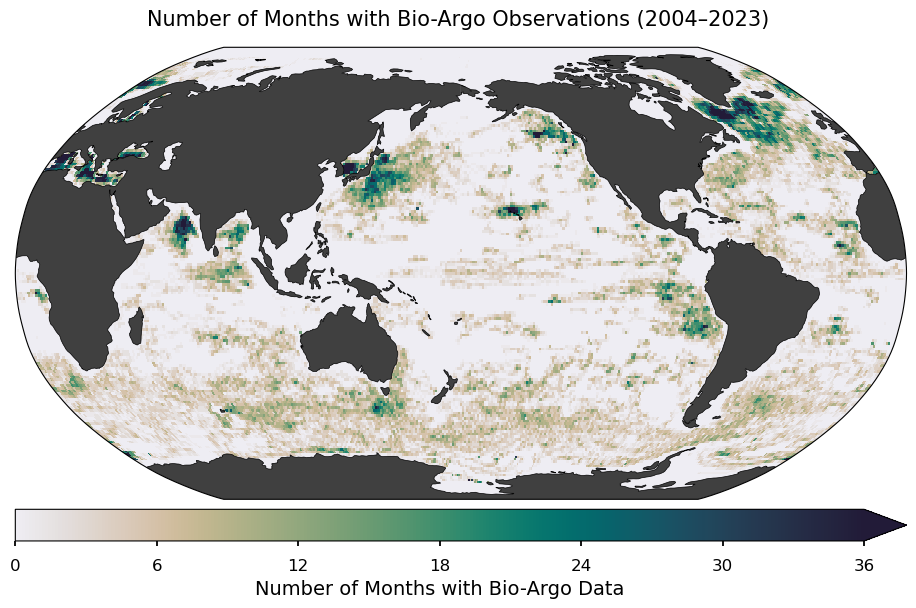

In [5]:
from matplotlib import style

# Step 1: Load and clean Bio-Argo data
df = pd.read_csv("argo_bio-profile_index.zip", compression='zip', comment="#")

# Step 2: Coordinate processing
df["longitude"] = (df["longitude"] + 360) % 360  # Convert longitude to 0-360° range
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d%H%M%S", errors="coerce")  # Parse datetime
df = df[(df["date"].dt.year >= 2004) & (df["date"].dt.year <= 2023)]  # Filter years 2004-2023

# Step 3: Grid binning
df["lat_bin"] = df["latitude"].apply(lambda x: np.floor(x))  # 1° latitude bins
df["lon_bin"] = df["longitude"].apply(lambda x: np.floor(x))  # 1° longitude bins

# Step 4: Extract year-month and count unique months with data
df["year_month"] = df["date"].dt.to_period("M")  # Create year-month period
unique_months = df.groupby(["lat_bin", "lon_bin", "year_month"]).size().reset_index()
month_counts = unique_months.groupby(["lat_bin", "lon_bin"]).size().reset_index(name="months_with_data")

# Step 5: Create 2D array (lat × lon)
lat_bins = np.arange(-90, 91)  # Latitude bins from -90° to 90°
lon_bins = np.arange(0, 361)  # Longitude bins from 0° to 360°
month_array = np.zeros((len(lat_bins), len(lon_bins)))  # Initialize empty grid

for _, row in month_counts.iterrows():
    lat_idx = int(row["lat_bin"] + 90)  # Convert to array index (-90° → 0)
    lon_idx = int(row["lon_bin"])  # Convert to array index (0° → 0)
    if 0 <= lat_idx < len(lat_bins) and 0 <= lon_idx < len(lon_bins):  # Boundary check
        month_array[lat_idx, lon_idx] = row["months_with_data"]

# Step 6: Convert to xarray and add cyclic point
ds_months = xr.DataArray(month_array, coords=[("ylat", lat_bins), ("xlon", lon_bins)])
ds_months = xr_add_cyclic_point(ds_months, cyclic_coord="xlon")  # For seamless global plot
ds_months = ds_months.assign_coords(xlon=(ds_months.xlon % 360))  # Ensure 0-360° range

# Step 7: Plotting
plot_style = "seaborn-v0_8-talk"
with style.context(plot_style):
    fig = plt.figure(figsize=(10, 6))
    worldmap = SpatialMap2(fig=fig, region="world", 
                           cbar_mode="each", colorbar=True,
                           cbar_location="bottom", nrows_ncols=[1, 1])

    # Visualization parameters
    vrange = [0, 36, 6]  # [min, max, step] for colorbar
    cmap = cm.cm.rain  # Colormap choice
    
    # Create main plot
    sub = worldmap.add_plot(lon=ds_months.xlon, lat=ds_months.ylat, data=ds_months, 
                            vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)

    # Add and format colorbar
    col = worldmap.add_colorbar(sub, ax=0, extend="max")
    worldmap.set_cbar_xlabel(col, "Number of Months with Bio-Argo Data", fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)

    # Add title
    plt.suptitle("Number of Months with Bio-Argo Observations (2004–2023)", fontsize=15)
    plt.tight_layout()
    plt.show()

Fig.1 : This visualization displays the spatial distribution of all Bio-Argo float observations collected between 2004 and 2023. Each point on the map represents a location where data was recorded, with color or size indicating the number of months for which measurements are available. Incorporating Bio-Argo data can enhance the spatial and temporal resolution of surface ocean pCO₂ reconstructions. This is particularly valuable in remote and under-sampled regions like the Southern Ocean, where traditional ship-based observations are limited.

Then, we created an argo mask and merged the mask in the Southern ocean with the socat mask, finally obtaining the argo_socat_mask.

Keep in mind also that this project only adds Bio-Argo data from the Southern Ocean to the SOCAT dataset. As you can see, in real life even more potential data is available!

In [6]:
## Create argo mask
# Step 1: Define time, lat, lon grid
time_range = pd.date_range("2004-01-01", "2023-12-01", freq="MS")  # Monthly start
lat_bins = np.arange(-89.5, 90.5, 1.0)  # 180 bins, centered
lon_bins = np.arange(0.5, 360.5, 1.0)   # 360 bins, centered

# Step 2: Add binned coordinates
df["lat_bin"] = np.floor(df["latitude"]) + 0.5
df["lon_bin"] = np.floor(df["longitude"]) + 0.5
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# Step 3: Create empty array and fill mask
argo_mask = np.zeros((len(time_range), len(lat_bins), len(lon_bins)), dtype=np.int8)

# Build index maps for fast fill
lat_idx_map = {v: i for i, v in enumerate(lat_bins)}
lon_idx_map = {v: i for i, v in enumerate(lon_bins)}
time_idx_map = {v: i for i, v in enumerate(time_range)}

# Only keep records with valid grid
df_valid = df[df["lat_bin"].isin(lat_bins) & df["lon_bin"].isin(lon_bins) & df["month"].isin(time_range)]

# Fill argo_mask
for _, row in df_valid.iterrows():
    t_idx = time_idx_map[row["month"]]
    y_idx = lat_idx_map[row["lat_bin"]]
    x_idx = lon_idx_map[row["lon_bin"]]
    argo_mask[t_idx, y_idx, x_idx] = 1  # Mark presence of data

# Step 4: Convert to xarray DataArray
argo_mask_data = xr.DataArray(
    argo_mask,
    dims=["time", "ylat", "xlon"],
    coords={
        "time": time_range,
        "ylat": lat_bins,
        "xlon": lon_bins
    },
    name="argo_mask"
)
# argo_mask_ds.to_netcdf("argo_mask_data.nc")
# Preview
argo_mask_ds = xr.Dataset({"argo_mask": argo_mask_data})
argo_mask_ds["xlon"] = argo_mask_ds["xlon"] - 180

In [7]:
# Create argo included socat mask
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]), str(dates[-1])))
socat_mask = socat_mask_data['socat_mask']
argo_mask = argo_mask_ds['argo_mask']

# Create a boolean DataArray representing the region south of 35°S
southern_hemisphere = socat_mask['ylat'] < -35

# Create a new DataArray to store the combined mask
argo_socat_mask = xr.where(
    southern_hemisphere,  # Condition: south of 35°S
    (socat_mask == 1) | (argo_mask == 1),  # If condition is met (south), mask is True (1) where either socat_mask OR argo_mask is 1
    socat_mask == 1  # If condition not met (north), mask follows socat_mask values
).astype(int)  # Convert boolean to integer (0 or 1)

# Create a new Xarray Dataset containing the merged mask
argo_socat_mask = xr.Dataset({'argo_mask': argo_socat_mask}, coords=socat_mask_data.coords)

### Total added samples and locations

By combining additional bio-argo data in the Southern ocean, total samples are increased by 44629 at 9707 locations.

In [8]:
added_points = (argo_socat_mask.argo_mask == 1) & (socat_mask_data.socat_mask == 0)
total_added_points_argo = added_points.sum(dim=['time', 'ylat', 'xlon'])
total_added_points_argo.values

array(44629)

In [9]:
added_points_spatial_argo = added_points.any(dim='time').sum()
added_points_spatial_argo.values

array(9707)

Comparing the new bio-argo added mask (argo_socat_mask) with the original socat mask (socat_mask_data), it can be seen that data coverage over the Southern ocean is signifcantly enhanced, as shown in Figure 2.

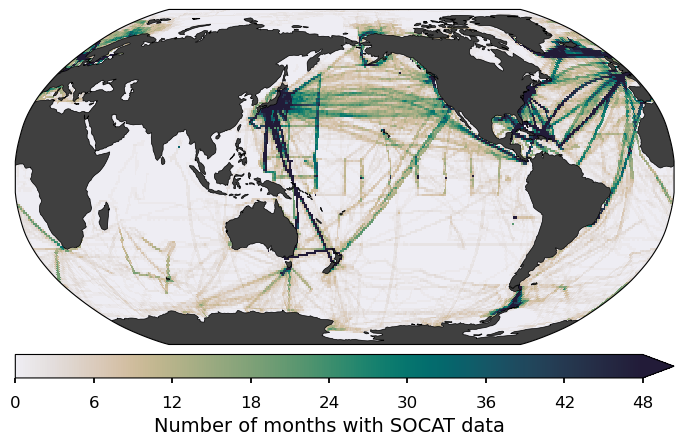

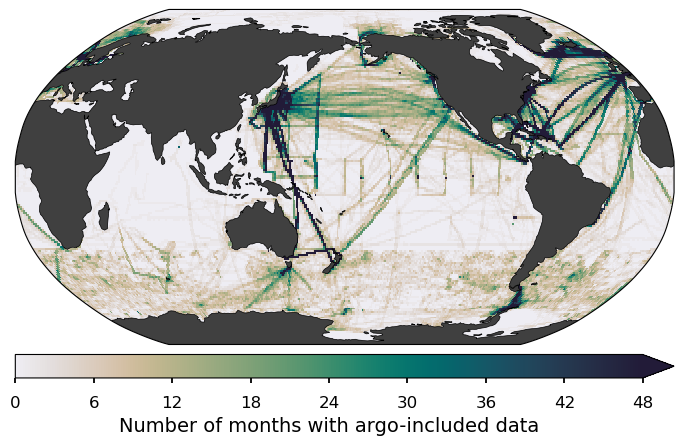

In [10]:
non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with SOCAT data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

non_zero_counts = (argo_socat_mask.argo_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with argo-included data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

Fig.2 (Top): A visualization of all SOCAT data between 2004-2023. The plot presents the number of months with available data. This surface ocean pCO₂ observation display a challenge since the data is sparse and unevenly distributed (coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator)). As seen in teh figure, SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

Fig.2 (Bottom): A snapshot visualization of Argo float observations at a specific point in time, in this example it is January 1, 2021. The numbers in the colorbar represent if the Argo float observations exist in yellow (1) or not in purple (0). The figure clearly show more Bio Argo observations in areas with sparse data like the Southern Ocean.

## 1.2 Input Sources with Bio Argo

Here we run the XGBoost model to reconstruct global pCO₂ from the ESM-generated pCO₂ observations at the SOCAT and Bio-Argo sampling locations

In [11]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

In [12]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"

In [66]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/luke0331/luke0331/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"


In [14]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(MLinputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [15]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


In [16]:
fs = gcsfs.GCSFileSystem()
ens0 = 'ACCESS-ESM1-5'
member_dir = f"{ensemble_dir}/{ens0}/{selected_mems_dict[ens0][0]}"
files = fs.ls(member_dir)

print("Files in GCS directory:")
for file in files:
    print(file)


Files in GCS directory:
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/chlclim_ACCESS-ESM1-5.r10i1p1f1.Omon.zarr


## 1.3 ML Reconstruction with Bio Argo

Here, argo-included mask (argo_socat_mask) was used to replace the original socat mask when training the model, while other parts remained the same.

In [17]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

In [18]:
params = {
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum depth of each tree to control model complexity
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'subsample': 0.8,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
    'gamma': 0.1,  # Minimum loss reduction required for further partitioning
    'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
    'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
    'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'n_jobs': 30,  # Number of parallel threads to use for training
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
}

In [20]:
runthiscell = 0  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell: 
    random_seeds = np.load(fs.open(path_seeds))   
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in mems_dict.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})
    
    val_prop = .2 # 20% of training data for validation
    test_prop = .0 # Since we apply this split to X_train, we set it to zero. We have X_test as testing dataset.
    
    print(datetime.datetime.now())

    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict
    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)

                argo_mask = argo_socat_mask["argo_mask"]
                index_coords = df.index.to_frame(index=False)
                index_coords['time'] = pd.to_datetime(index_coords['time'])
                index_coords['xlon'] = index_coords['xlon'].astype(float)
                index_coords['ylat'] = index_coords['ylat'].astype(float)
                new_mask_values = argo_mask.sel(
                    time=xr.DataArray(index_coords['time'], dims="points"),
                    xlon=xr.DataArray(index_coords['xlon'], dims="points"),
                    ylat=xr.DataArray(index_coords['ylat'], dims="points"),
                    method="nearest"  
                ).values
                df['argo_mask'] = new_mask_values
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['argo_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['argo_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
                Xtrain = df.loc[train_sel, features_sel].to_numpy()                
                ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
    
                X_test = df.loc[test_sel, features_sel].to_numpy()
                y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
                N = Xtrain.shape[0]
                
                train_val_idx, train_idx, val_idx, test_idx = supporting_functions.train_val_test_split(
                    N, test_prop, val_prop, random_seeds, seed_loc
                )
                X_train_val, X_train, X_val, X_test_tmp, y_train_val, y_train, y_val, y_test_tmp = \
                    supporting_functions.apply_splits(Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx)   
    
            train_performance = defaultdict(dict)
            test_performance = defaultdict(dict)
    
            model = XGBRegressor(
                random_state=random_seeds[5, seed_loc],
                **params,
            )
            eval_set = [(X_val, y_val)] 
            model.fit(
                X_train_val, y_train_val, 
                eval_set=eval_set, 
                verbose=False
            )
            ens_argo = ens + "_argo"
            supporting_functions.save_model_locally(model, dates, xgb_model_local_save_dir, ens_argo, member)
    
            y_pred_test = model.predict(X_test)
          
            test_performance[ens][member] = supporting_functions.evaluate_test(y_test, y_pred_test)
    
            fields = test_performance[ens][member].keys()
            test_row_dict = dict()
            test_row_dict['model'] = ens_argo
            test_row_dict['member'] = member
            
            for field in fields:
                test_row_dict[field] = test_performance[ens][member][field]

            argo_test_perform_fname = test_perform_fname.replace(".csv", "_argo.csv")
            
            file_exists = fs.exists(argo_test_perform_fname)
            with fs.open(argo_test_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(test_row_dict)
            print('test performance metrics:', test_performance[ens][member])
            
    print('end of all members', datetime.datetime.now())

In [21]:
# Reconstruction:

runthiscell = 0  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            ens_argo = ens + "_argo"
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens_argo}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
         
            # model = xgb.XGBRegressor()
            # model.load_model(model_path)
            booster = xgb.Booster()
            booster.load_model(model_path)
            
            model = xgb.XGBRegressor()
            model._Booster = booster
            model._le = None 
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)

                argo_mask = argo_socat_mask["argo_mask"]

                index_coords = df.index.to_frame(index=False)
                index_coords['time'] = pd.to_datetime(index_coords['time'])
                index_coords['xlon'] = index_coords['xlon'].astype(float)
                index_coords['ylat'] = index_coords['ylat'].astype(float)
                new_mask_values = argo_mask.sel(
                    time=xr.DataArray(index_coords['time'], dims="points"),
                    xlon=xr.DataArray(index_coords['xlon'], dims="points"),
                    ylat=xr.DataArray(index_coords['ylat'], dims="points"),
                    method="nearest"  
                ).values
                df['argo_mask'] = new_mask_values
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['argo_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['argo_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
            y_pred_unseen = model.predict(df.loc[unseen_sel, features_sel].to_numpy())
            y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
            
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens_argo
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            file_exists = fs.exists(unseen_perform_fname)
            with fs.open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('unseen performance metrics:', unseen_performance[ens][member])
    
            y_pred_seen = model.predict(X)
            
            df['pCO2_recon_full'] = np.nan
        
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens_argo, member)
        
    print('end of all members', datetime.datetime.now())

In [22]:
## Add temperature back

runthiscell = 0  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)



## 1.4 Evaluation of the Argo Bio reconstruction against the original model output

How much, where, and when does including Bio-Argo data improve reconstructions of pCO₂ from the large ensemble testbed?

In [60]:
# Original
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, xlon: 360, time: 240, ylat: 180, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


In [67]:
# Argo included
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets_argo(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval_argo = evaluator.compute_all_metrics()
print(ds_eval_argo)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, time: 240, ylat: 180, xlon: 360, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


### Descriptive Statistics and Calculate Bias

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

#### Northern Hemisphere:
The mean bias for argo_included model is -0.452, which is slightly lower than the original model (-0.442) but generally didn't change much, which is feasible given the fact that only bio-argos in the Southern ocean were added in the new mask.
- Original model

In [62]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.441840
std          3.212339
min        -54.107506
25%         -1.687151
50%         -0.256871
75%          1.097673
max         20.998117
Name: bias, dtype: float64

- Argo-included model

In [68]:
ds_eval_argo_mean = (ds_eval_argo['bias']*1).mean('ens').mean('time')
ds_eval_argo_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.451742
std          3.270774
min        -49.099347
25%         -1.718729
50%         -0.254502
75%          1.128705
max         25.547270
Name: bias, dtype: float64

#### Southern Hemisphere:
The mean bias for argo_included model is -0.015, which is significantly smaller than the original model (-0.145), and standard deviation also dropped from 3.90 to 3.31, indicating that the inclusion of bio-argos is effective in reducing bias in the Southern ocean and building more robust pCO2 reconstructions.
- Original model

In [27]:
ds_eval_mean.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    172048.000000
mean         -0.145469
std           3.901953
min         -45.061345
25%          -1.798515
50%           0.251198
75%           2.018014
max          49.616688
Name: bias, dtype: float64

- Argo-included model

In [28]:
ds_eval_argo_mean.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    172048.000000
mean         -0.015275
std           3.307640
min         -44.369974
25%          -1.260430
50%           0.173716
75%           1.508004
max          71.543391
Name: bias, dtype: float64

### Bias Visualizations: How well does the Bio Argo reconstruction capture the mean pCO2 field?

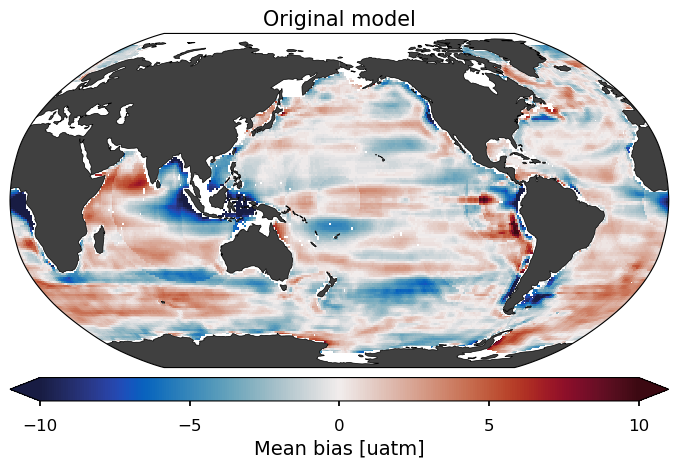

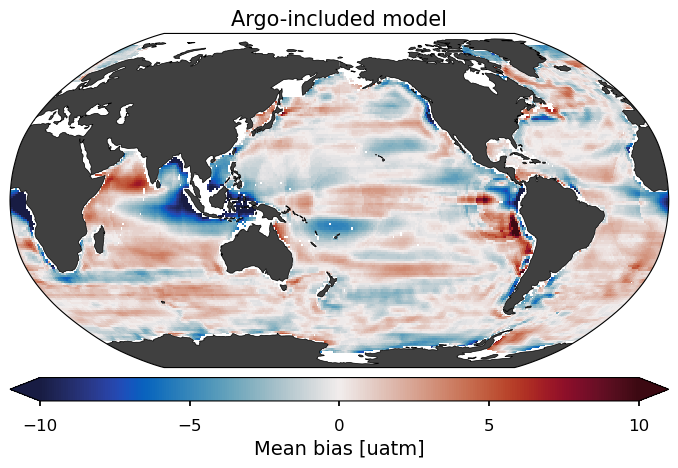

In [29]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plot_title = 'Original model' 
    worldmap.set_title(plot_title, ax=0, fontsize=15) 
    plt.show()

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval_argo['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plot_title = 'Argo-included model' 
    worldmap.set_title(plot_title, ax=0, fontsize=15) 
    plt.show()

Fig. 3: This map visualize the mean spatial bias of pCO₂ (units "µatm") from a the Bio Argo dataset over the entire globe. As seen in the map, there is less bias in the model, especially in the Southern Hemisphere when using Bio Argo masking.

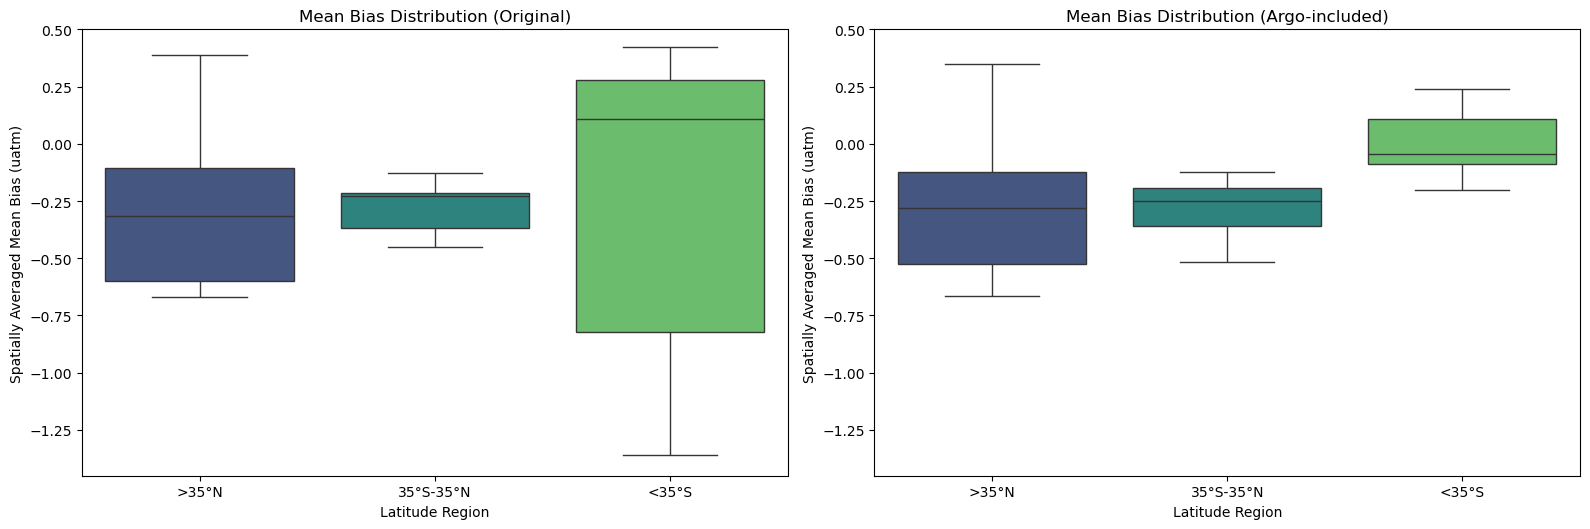

In [30]:
import seaborn as sns

def calculate_regional_mean_bias(ds):

    regional_mean_bias = []
    for region_name in ['>35°N', '35°S-35°N', '<35°S']:
        if region_name == '>35°N':
            region_mask = ds['ylat'] > 35
        elif region_name == '<35°S':
            region_mask = ds['ylat'] < -35
        else:
            region_mask = (ds['ylat'] >= -35) & (ds['ylat'] <= 35)

        regional_mean = ds['bias'].where(region_mask, drop=True).mean(dim=['ylat', 'xlon', 'time'])

        for en_idx, en in enumerate(ds['ens'].values):
            for mem_idx, mem in enumerate(ds['member'].values):
                bias_value = regional_mean.sel(ens=en, member=mem).compute().item()
                regional_mean_bias.append({
                    'region': region_name,
                    'bias': bias_value,
                    'ens': en,
                    'member': mem
                })
    return pd.DataFrame(regional_mean_bias)

df_regional_mean = calculate_regional_mean_bias(ds_eval)
df_regional_mean_argo = calculate_regional_mean_bias(ds_eval_argo)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First boxplot (ds_eval)
sns.boxplot(x='region', y='bias', data=df_regional_mean, palette='viridis', order=['>35°N', '35°S-35°N', '<35°S'], ax=axes[0], hue='region', legend=False)
axes[0].set_title('Mean Bias Distribution (Original)')
axes[0].set_xlabel('Latitude Region')
axes[0].set_ylabel('Spatially Averaged Mean Bias (uatm)')
axes[0].set_ylim(-1.45, 0.5)

# Second boxplot (ds_eval_argo)
sns.boxplot(x='region', y='bias', data=df_regional_mean_argo, palette='viridis', order=['>35°N', '35°S-35°N', '<35°S'], ax=axes[1], hue='region', legend=False)
axes[1].set_title('Mean Bias Distribution (Argo-included)')
axes[1].set_xlabel('Latitude Region')
axes[1].set_ylabel('Spatially Averaged Mean Bias (uatm)')
axes[1].set_ylim(-1.45, 0.5)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Fig. 4: This diagram analyzes and visualizes how the mean model bias varies across three broad latitude - Northern Hemisphere, Southern Hemisphere, and the area between (around the equator). After implementing the Bio Argo masking, the Southern Hemispher has become much less biased, the Northern Hemisphere bias almost stayed the same compared to the original model, and the area around the equator got a little bit less biased than the Northern Hemisphere. 

## 1.5 Argo monthly climatology (Gloege et al. paper)

In the Gloege et al. paper, they supplemented real world SOCAT sampling in the Southern Ocean using historical sample locations of all SOCCOM and CARIOCA measurements collapsed to a monthly climatology. These samples are assumed to have occurred at the same locations every year, and adds 114,972 additional samples at 592 locations. To replicate what they did, here we aggregate all locations that are sampled more than once to derive a monthly climatology for 2004-2023, which ends up adding 130,233 additional samples, a number close to that in the paper. Following that, we explored whether such increase in samples from 45k to 130k would bring additional improvement on the reconstruction accuracy.

In [31]:
argo_mask = argo_mask_ds['argo_mask']
months = np.unique(argo_mask['time'].dt.month)
argo_clim_data = xr.zeros_like(argo_mask)

for month in months:
    monthly_argo_mask = argo_mask.sel(time=argo_mask['time'].dt.month == month)
    monthly_sample_count = monthly_argo_mask.sum(dim='time')

    threshold = 2
    valid_locations_mask = monthly_sample_count >= threshold
    valid_monthly_mask = monthly_argo_mask.where(valid_locations_mask, 0).any(dim='time')
    argo_clim_data = argo_clim_data.where(
        ~(argo_clim_data['time'].dt.month == month), valid_monthly_mask)

argo_clim_ds = xr.Dataset({'argo_mask': argo_clim_data}, coords=argo_mask.coords)

# combine socat with argo climatology
socat_mask = socat_mask_data['socat_mask']
argo_mask = argo_clim_ds['argo_mask']
southern_hemisphere = socat_mask['ylat'] < -35

# Create a new DataArray to store the combined mask
argo_socat_mask = xr.where(
    southern_hemisphere,  # Condition: south of equator
    (socat_mask == 1) | (argo_mask == 1),  # If condition is met (south), mask is True (1) where either socat_mask OR argo_mask is 1
    socat_mask == 1  # If condition not met (north), mask follows socat_mask values
).astype(int)  # Convert boolean to integer (0 or 1)

argo_socat_clim_mask = xr.Dataset({'argo_mask': argo_socat_mask}, coords=socat_mask_data.coords)

# Total added sampling points
added_points = (argo_socat_clim_mask.argo_mask == 1) & (socat_mask_data.socat_mask == 0)
total_added_points = added_points.sum(dim=['time', 'ylat', 'xlon'])
total_added_points.values

array(130233)

In [32]:
added_points_spatial = added_points.any(dim='time').sum()
added_points_spatial.values

array(3694)

In [33]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets_argo_clim(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval_argo_clim = evaluator.compute_all_metrics()
print(ds_eval_argo_clim)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, xlon: 360, time: 240, ylat: 180, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


### Bias

However, when comparing to the argo model that only includes 45k additional samples, the argo-climatology model underperformed. The mean bias over northern hemisphere is slightly bigger (-0.467 vs -0.452 uatm) and the mean bias over southern hemisphere is significantly bigger (-0.079 vs -0.015 uatm).

#### Northern Hemisphere:

In [34]:
ds_eval_argo_clim_mean = (ds_eval_argo_clim['bias']*1).mean('ens').mean('time')
ds_eval_argo_clim_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.467183
std          3.274987
min        -49.480676
25%         -1.757389
50%         -0.230871
75%          1.166925
max         22.829478
Name: bias, dtype: float64

#### Southern Hemisphere:

In [35]:
ds_eval_argo_clim_mean.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    171992.000000
mean         -0.079778
std           3.361237
min         -43.940596
25%          -1.270881
50%           0.123815
75%           1.418297
max          80.789799
Name: bias, dtype: float64

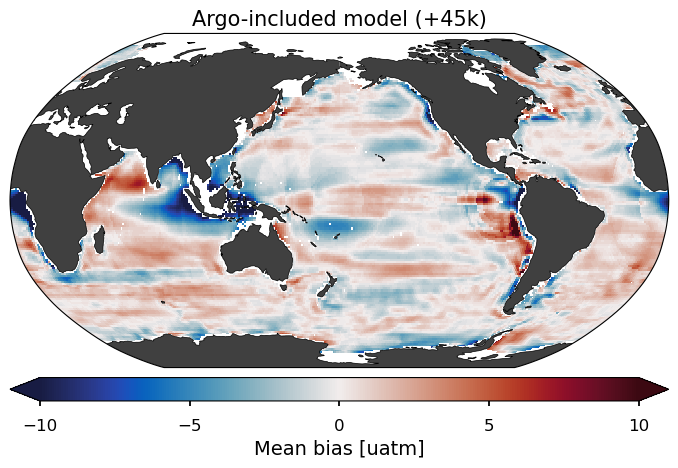

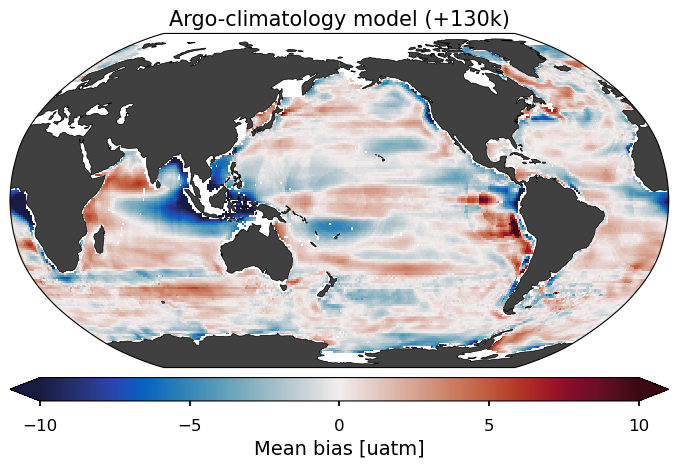

In [36]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval_argo['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plot_title = 'Argo-included model (+45k)' 
    worldmap.set_title(plot_title, ax=0, fontsize=15) 
    plt.show()

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval_argo_clim['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plot_title = 'Argo-climatology model (+130k)' 
    worldmap.set_title(plot_title, ax=0, fontsize=15) 
    plt.show()

Fig. 5: This maps present two separate global maps that visualize the mean bias in surface ocean pCO₂ reconstructions using two different models: Mean bias of XGBoost model trained on the the realistic Bio-Argo and SOCAT data mask developed in this project, +45k samples (top), and compared to the mean bias of the quasi-replicated monthly climatology Bio-Argo mask developed by Gloege et al. (2021). +130k samples (bottom).

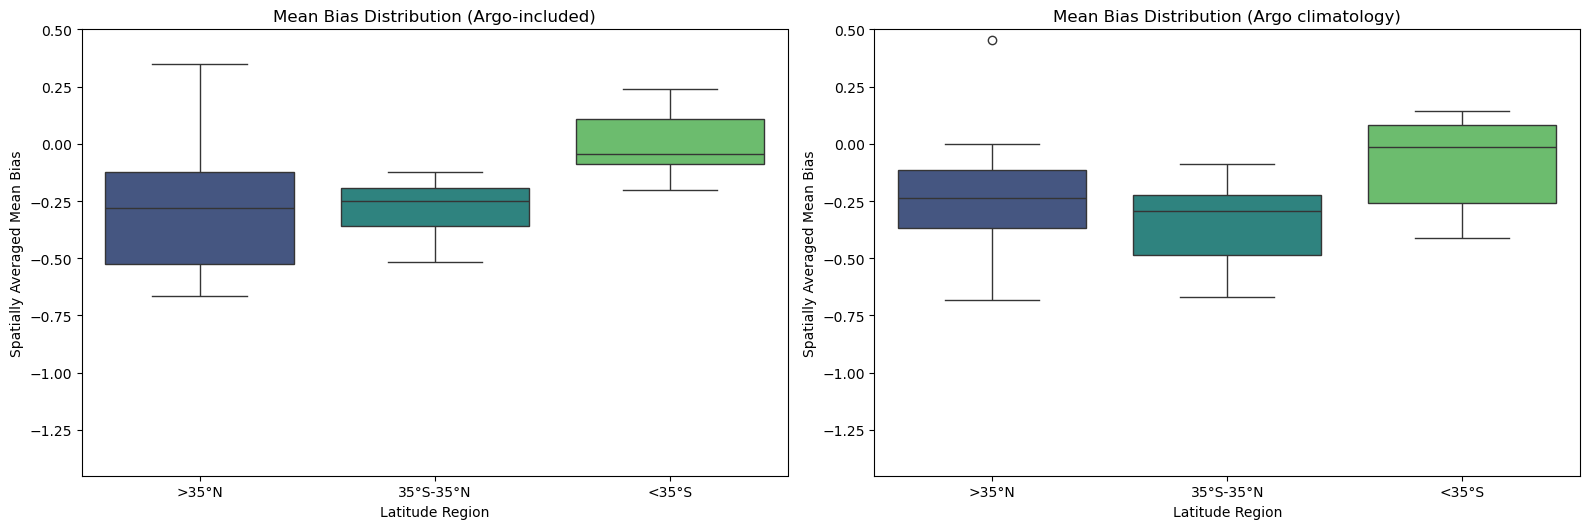

In [37]:
df_regional_mean_argo_clim = calculate_regional_mean_bias(ds_eval_argo_clim)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First boxplot (ds_eval)
sns.boxplot(x='region', y='bias', data=df_regional_mean_argo, palette='viridis', order=['>35°N', '35°S-35°N', '<35°S'], ax=axes[0], hue='region', legend=False)
axes[0].set_title('Mean Bias Distribution (Argo-included)')
axes[0].set_xlabel('Latitude Region')
axes[0].set_ylabel('Spatially Averaged Mean Bias')
axes[0].set_ylim(-1.45, 0.5)

# Second boxplot (ds_eval_argo)
sns.boxplot(x='region', y='bias', data=df_regional_mean_argo_clim, palette='viridis', order=['>35°N', '35°S-35°N', '<35°S'], ax=axes[1], hue='region', legend=False)
axes[1].set_title('Mean Bias Distribution (Argo climatology)')
axes[1].set_xlabel('Latitude Region')
axes[1].set_ylabel('Spatially Averaged Mean Bias')
axes[1].set_ylim(-1.45, 0.5)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Fig. 6: This plots show two side-by-side boxplots to compare the distribution of spatially averaged mean pCO₂ bias across different latitude regions (greater than 35°N, between 35°S and 35°N, and less than 35°S) for two different model versions: Spatially averaged mean bias by latitude region for the realistic Bio-Argo mask developed in this project (left) and a quasi-replication of the climatology Bio-Argo mask developed by Gloege et al. (2021). Middle horizontal lines of the boxplots represent the median, upper and lower box boundaries contain the middle 50% of the data (interquartile range), and the upper and lower vertical lines contain 1.5 times the interquartile range.

## 1.6 Cross-comparison

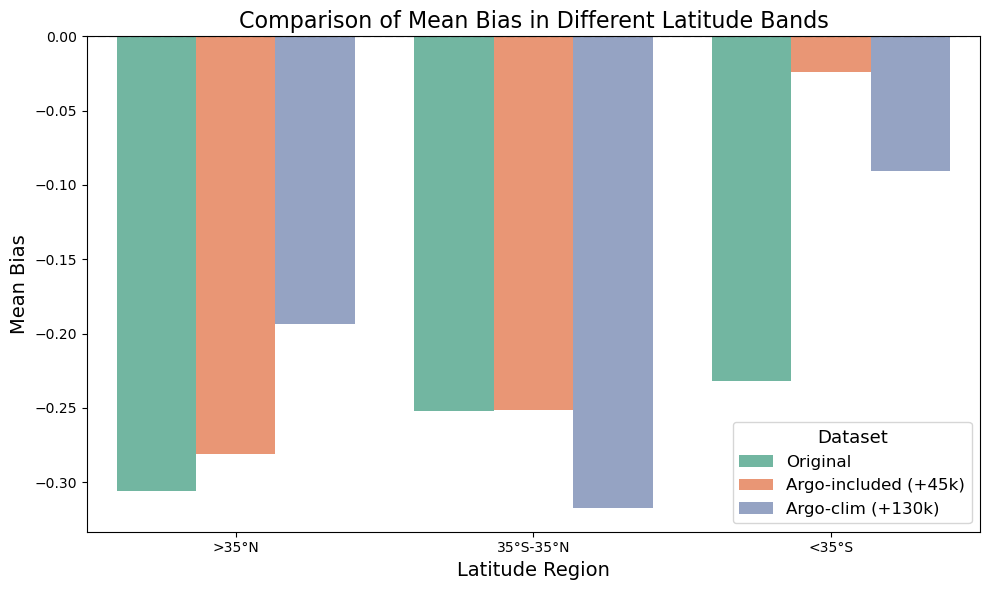

In [38]:
def calculate_region_mean(ds_mean):
    results = {}
    
    # >35°N
    region_north = ds_mean.sel(ylat=slice(35, 90)).stack(z=['ylat', 'xlon']).dropna('z')
    results['>35°N'] = region_north.to_dataframe().describe()['bias']['mean']
    
    # 35°S ~ 35°N
    region_tropics = ds_mean.sel(ylat=slice(-35, 35)).stack(z=['ylat', 'xlon']).dropna('z')
    results['35°S-35°N'] = region_tropics.to_dataframe().describe()['bias']['mean']
    
    # <35°S
    region_south = ds_mean.sel(ylat=slice(-90, -35)).stack(z=['ylat', 'xlon']).dropna('z')
    results['<35°S'] = region_south.to_dataframe().describe()['bias']['mean']
    
    return results

ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_argo_mean = (ds_eval_argo['bias']*1).mean('ens').mean('time')
ds_eval_argo_clim_mean = (ds_eval_argo_clim['bias']*1).mean('ens').mean('time')

results_eval = calculate_region_mean(ds_eval_mean)
results_argo = calculate_region_mean(ds_eval_argo_mean)
results_argo_clim = calculate_region_mean(ds_eval_argo_clim_mean)

df_plot = pd.DataFrame({
    'Original': results_eval,
    'Argo-included (+45k)': results_argo,
    'Argo-clim (+130k)': results_argo_clim
}).T 

df_plot_reset = df_plot.reset_index().melt(id_vars='index', var_name='Region', value_name='Mean Bias')
df_plot_reset.rename(columns={'index': 'Dataset'}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Region', y='Mean Bias', hue='Dataset', data=df_plot_reset, palette='Set2')

plt.title('Comparison of Mean Bias in Different Latitude Bands', fontsize=16)
plt.xlabel('Latitude Region', fontsize=14)
plt.ylabel('Mean Bias', fontsize=14)
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Dataset', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

Fig. 7: This plot compares the average pCO₂ mean bias across three major latitude regions (>35°N, 35°S–35°N, and <35°S) for three different model setups: original (green), realistic Bio-Argo (orange) and quasi-replicated Bio-Argo monthly climatology (pruple) experiments. Numbers in parentheses indicate the total number of sampling points added relative to the original (SOCAT only) experiment.

It can be seen that, increasing sampling in the Southern ocean can significantly reduce the mean bias. However, such increase is not necessarily proportional to the amount of total samples, especially when using monthly climatology where there are lots of repetitive locations. For realistic argo data, the increase of ~45k samples occurred at 9707 locations, whereas the ~130k samples of climatological argos only occurred at 3694 locations, which encoded much lower spatial representativeness. Repetitive sample locations might also lead the model to overfit and suffer from generalization. Therefore, the monthly climatology approaches used in the paper cannot objectively reflect the effect of realistic Southern ocean sampling on reconstruction performance. In reality, better accuracy can be achieved through much lower sampling efforts.

# 2. SOCAT Mirroring Code

## Setup Workspace and Data Storage

In [53]:
your_username = 'ian_shuman'
owner_username = 'ian_shuman'

In [54]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"

In [55]:
#print(recon_output_dir)
fs.ls(recon_output_dir)

['leap-persistent/ian_shuman/ian_shuman/pco2_residual/nmse/post02_xgb/reconstructions/ACCESS-ESM1-5',
 'leap-persistent/ian_shuman/ian_shuman/pco2_residual/nmse/post02_xgb/reconstructions/CanESM5',
 'leap-persistent/ian_shuman/ian_shuman/pco2_residual/nmse/post02_xgb/reconstructions/MPI-ESM1-2-LR']

## 2.1 Mirroring 30% of Northern Hemisphere SOCAT points into the Southern Hemisphere

Rather than deploying Bio-Argo floats, another (albeit more expensive) way that we could increase sampling of PCO2 in the ocean is by increasing the sampling effort of research cruises (ie sending out more research cruises). Further, we can say that we might focus that sampling effort on globally undersampled areas, such as the Southern Hemisphere. Much like Gloege et al. did for Bio-Argo data, we can then pretend that we've done this sampling effort since the 1980s to see how that additional data would impact the bias of our testbed PCO2 reconstructions. 

To create this hypothetical sampling scenario, we can simply "mirror" sampling efforts in the Northern Hemisphere into the Southern Hemisphere. So, if a research cruise went out into the North Atlantic, this technique will create new sampling locations in the South Atlantic at the same longitude, but the exactly negative latitude, as the research cruise in the North Atlantic. We will do this "mirroring" technique for 30% of samples collected in the Northern Hemisphere from 1980-present. 

In [56]:
# 1. Get the original mask and latitudes
original_mask = socat_mask_data["socat_mask"]
lat_vals = socat_mask_data.ylat
lon_vals = socat_mask_data.xlon
time_vals = socat_mask_data.time

# 2. Create a copy to store the mirrored version
mirrored_mask = original_mask.copy(deep=True)

# 3. Identify valid northern hemisphere mask positions
bool_mask = ((lat_vals > 0) & (original_mask == 1)).compute()
northern_masked = original_mask.where(bool_mask)

# 4. Sample subset of northern latitudes
unique_northern_lats = np.unique(northern_masked.ylat.dropna("ylat").values)
sample_frac = 0.3
sampled_lat_indices = np.random.choice(len(unique_northern_lats), int(sample_frac * len(unique_northern_lats)), replace=False)
sampled_lats = unique_northern_lats[sampled_lat_indices]

# 5. Mirror the selected latitudes across all time steps
for lat in sampled_lats:
    mirrored_lat = -lat
    if mirrored_lat in lat_vals.values:
        # Get mask data for northern latitude across time and lon
        north_data = original_mask.sel(ylat=lat)
        south_data = original_mask.sel(ylat=mirrored_lat)

        # Create new values: where north_data is 1, set south to 1
        updated_data = xr.where((north_data > 0) , 1, south_data)

        # Store result in mirrored mask
        mirrored_mask.loc[dict(ylat=mirrored_lat)] = updated_data

# 6. Create a new dataset with the mirrored mask
mirrored_mask_ds = xr.Dataset(
    {"socat_mask": mirrored_mask},
    coords={"time": time_vals, "ylat": lat_vals, "xlon": lon_vals}
)

original_mask_ds = xr.Dataset(
    {"socat_mask": original_mask},
    coords={"time": time_vals, "ylat": lat_vals, "xlon": lon_vals}
)


In [57]:
#Total data added by mirroring
original_valid_count = (original_mask == 1).sum().compute().item()
mirrored_valid_count = (mirrored_mask == 1).sum().compute().item()
additional_points_added = mirrored_valid_count - original_valid_count
print(f"Additional data added: {additional_points_added}")

#Number of new sampling locations added by mirroring
orig_mask = original_mask_ds['socat_mask'].any(dim='time')  # shape: (ylat, xlon)
mir_mask = mirrored_mask_ds['socat_mask'].any(dim='time')
new_points_mask = (orig_mask == 0) & (mir_mask == 1)
n_new = new_points_mask.sum().compute().item()
print(f"New sampling locations added by mirroring (0 ➝ 1): {n_new}")


Additional data added: 84304
New sampling locations added by mirroring (0 ➝ 1): 4850


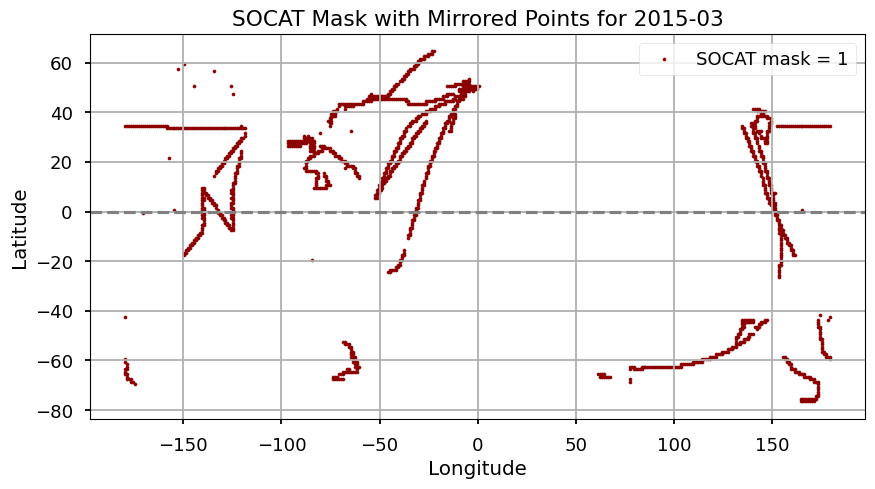

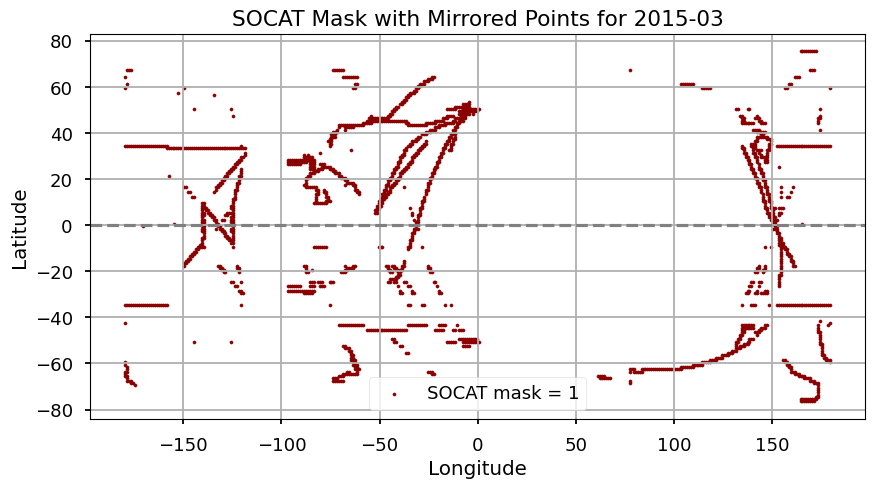

In [58]:
#Visualize mirroring for a given time
chosen_time = '2015-03'
mask = mirrored_mask_ds.sel(time=chosen_time)["socat_mask"].squeeze()
old_mask = original_mask.sel(time=chosen_time).squeeze()
import matplotlib.pyplot as plt

#Plot the data for the original mask at the chosen time
# Convert longitude to -180 to 180 if needed
lon = (((old_mask.xlon + 180) % 360) - 180)
lat = old_mask.ylat

# Create meshgrid for plotting
lon2d, lat2d = np.meshgrid(lon, lat)

# Masked values: only show where mask == 1
old_mask_data = old_mask.values
old_masked_points = np.where(old_mask_data == 1)

plt.figure(figsize=(10, 5))
plt.scatter(lon2d[old_masked_points], lat2d[old_masked_points], s=5, c='darkred', label='SOCAT mask = 1')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"SOCAT Mask with Mirrored Points for {chosen_time}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

#Plot the data for the mirrored mask at the chosen time
# Convert longitude to -180 to 180 if needed
lon = (((mask.xlon + 180) % 360) - 180)
lat = mask.ylat

# Create meshgrid for plotting
lon2d, lat2d = np.meshgrid(lon, lat)

# Masked values: only show where mask == 1
mask_data = mask.values
masked_points = np.where(mask_data == 1)

plt.figure(figsize=(10, 5))
plt.scatter(lon2d[masked_points], lat2d[masked_points], s=5, c='darkred', label='SOCAT mask = 1')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"SOCAT Mask with Mirrored Points for {chosen_time}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

Fig. 8: This figure provides an illustrative example of the mirroring technique applied to the SOCAT dataset for March 2015. The top panel shows the original distribution of available pCO₂ measurements, highlighting the inherent spatial gaps—particularly in the Southern Hemisphere. In contrast, the bottom panel displays the same dataset after applying a hemispheric mirroring technique (subset of 30% of the available latitude points).
The result is a more spatially complete dataset, which can be useful for training machine learning models and analyzing hemispheric patterns in ocean carbon dynamics. While this approach does not represent new, real-life data, it offers a creative way to explore how realistic increases in sampling from research cruises (as opposed to Bio-Argo floats) might improve reconstructions of ocean pCO₂.

## 2.2 Evaluation of the Mirroring Mask

In [47]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_mirrored_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
mir_concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(mir_concated_dataset)

mir_ds_eval = evaluator.compute_all_metrics()
print(mir_ds_eval)

member_r10i1p1f1
member_r5i1p1f1
member_r2i1p1f1
member_r2i1p1f1
member_r1i1p2f1
member_r1i1p1f1
member_r12i1p1f1
member_r11i1p1f1
member_r15i1p1f1
<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, xlon: 360, time: 240, ylat: 180, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 30, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndar

### Descriptive statistics of the mirrored runs' bias

In [49]:
# descriptive statistics of the mirrored runs' bias
mir_ds_eval_mean = (mir_ds_eval['bias']*1).mean('ens').mean('time')
mir_ds_eval_mean.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    172048.000000
mean         -0.148285
std           3.585837
min         -52.182145
25%          -1.650037
50%           0.067160
75%           1.612490
max          66.744024
Name: bias, dtype: float64

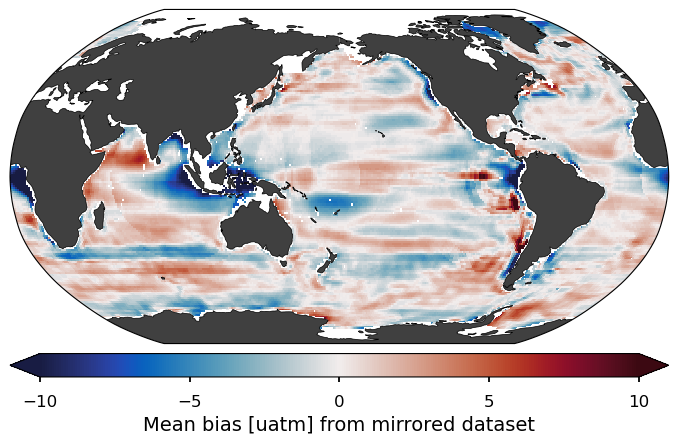

In [50]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (mir_ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    plot_title = 'Mirrored data model (+74k)' 
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm] from mirrored dataset', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

Fig. 9 : A global spatial map of the mean bias values from the mirrored dataset (30% mirrored SOCAT pCO₂) over all ensemble and time dimensions. 

In [51]:
#descriptive statistics of the original runs' bias
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    172048.000000
mean         -0.145469
std           3.901953
min         -45.061345
25%          -1.798515
50%           0.251198
75%           2.018014
max          49.616688
Name: bias, dtype: float64

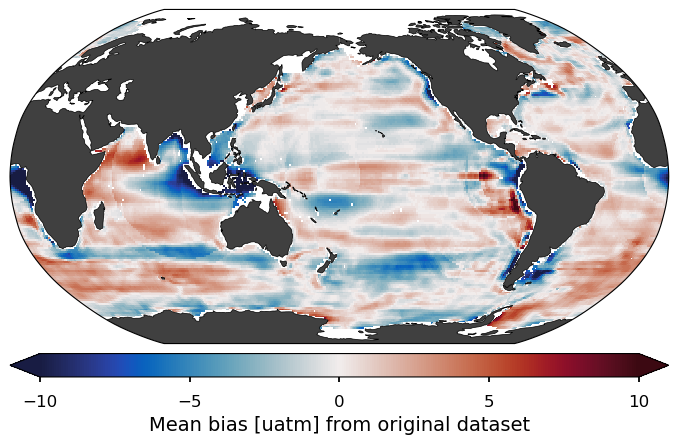

In [52]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    plot_title = 'Original model (+0)' 
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm] from original dataset', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

Fig. 10: This code generates a global map of the mean bias from the original dataset. We see deeper colors in the Southern Hemisphere in this figure compared to those from figure 9, where more data was added to simulate greater sampling effort from research cruises. We'll make a more quantitative comparison between these sampling scenarios later. 

## 2.3 Comparing the performance of the original, Bio-Argo and mirrored sampling scenarios over space 

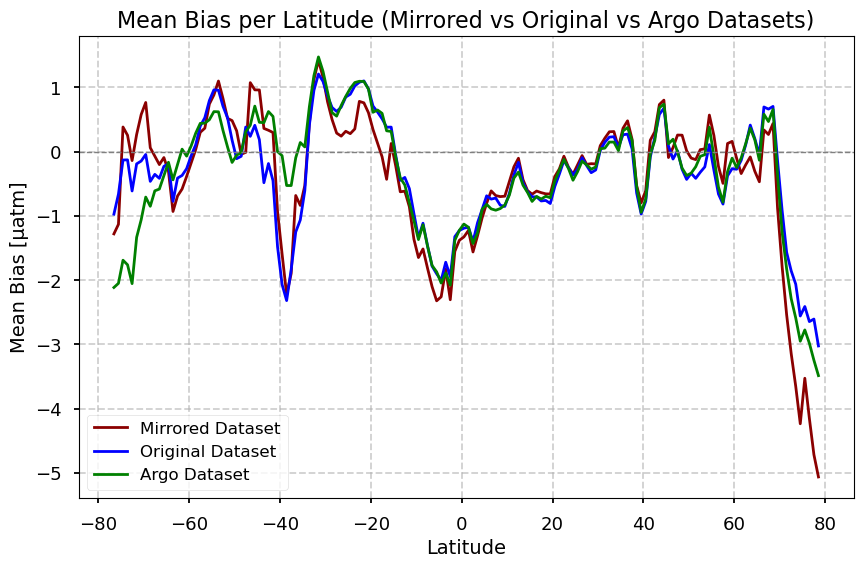

In [53]:
# Calculate the zonal mean bias for both arog, mirrored and original datasets
zonal_mean_bias_mirrored = (mir_ds_eval['bias'] * 1).mean('ens').mean('member').mean('time').mean(dim='xlon')
zonal_mean_bias_original = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time').mean(dim='xlon')
zonal_mean_bias_argo = (ds_eval_argo['bias'] * 1).mean('ens').mean('member').mean('time').mean(dim='xlon')

# Plot the zonal mean bias for both datasets
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    plt.figure(figsize=(10, 6))
    
    # Plot mirrored dataset
    plt.plot(zonal_mean_bias_mirrored['ylat'], zonal_mean_bias_mirrored, color='darkred', linewidth=2, label='Mirrored Dataset')
    
    # Plot original dataset
    plt.plot(zonal_mean_bias_original['ylat'], zonal_mean_bias_original, color='blue', linewidth=2, label='Original Dataset')

    # Plot argo dataset
    plt.plot(zonal_mean_bias_argo['ylat'], zonal_mean_bias_argo, color='green', linewidth=2, label='Argo Dataset')
    
    # Add a horizontal line at 0
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Add title and labels
    plt.title("Mean Bias per Latitude (Mirrored vs Original vs Argo Datasets)", fontsize=16)
    plt.xlabel("Latitude", fontsize=14)
    plt.ylabel("Mean Bias [µatm]", fontsize=14)
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Show the plot
    plt.show()

Fig. 11: This plot shows the zonal mean bias (i.e., average bias across longitudes for each latitude) for three different datasets: mirrored (red) original (blue), and Argo (green).

In figure 11, we see that all three sampling scenarios have similar bias in the northern latitudes. In the southern (negative) latitudes, it seems that the Argo dataset performs the best, followed by the mirrored dataset, and the original dataset performs the worst, which is what we might expect. But, let's investigate these spatial trends in a bit more detail to see where (spatially) and when (temporally) each sampling scenario dataset leads to the greatest improvements.

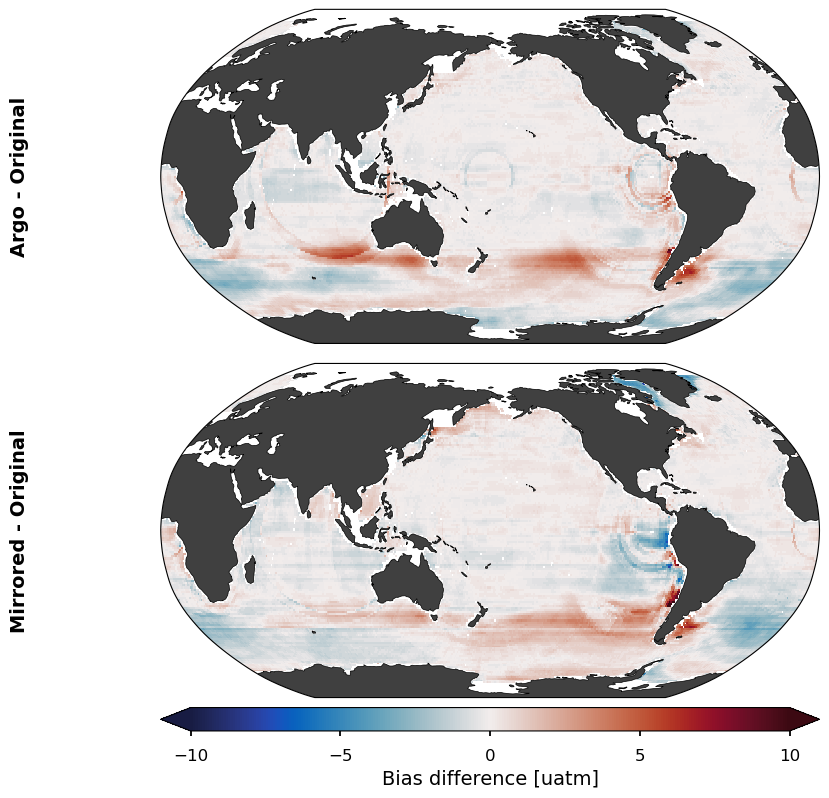

In [54]:
#Plot the change in bias over space
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11))
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='edge',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[2,1])  # Two rows, one column
    
    # Color range and colormap
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance

    # ----------------------------------------
    # Panel 1: Argo - Original
    argo_bias = ds_eval_argo['bias'].mean('ens').mean('member').mean('time')
    original_bias = ds_eval['bias'].mean('ens').mean('member').mean('time')
    
    diff_argo = (argo_bias - original_bias).roll(xlon=len(argo_bias.xlon)//2, roll_coords=True)
    diff_argo = xr_add_cyclic_point(diff_argo, cyclic_coord='xlon')

    sub0 = worldmap.add_plot(lon=diff_argo['xlon'], lat=diff_argo['ylat'], data=diff_argo, 
                             vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)

    worldmap.grid[0].text(-0.2, 0.5, "Argo - Original", transform=worldmap.grid[0].transAxes,
                          fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    # ----------------------------------------
    # Panel 2: Mirrored - Original
    mirrored_bias = mir_ds_eval['bias'].mean('ens').mean('member').mean('time')
    
    diff_mir = (mirrored_bias - original_bias).roll(xlon=len(mirrored_bias.xlon)//2, roll_coords=True)
    diff_mir = xr_add_cyclic_point(diff_mir, cyclic_coord='xlon')

    sub1 = worldmap.add_plot(lon=diff_mir['xlon'], lat=diff_mir['ylat'], data=diff_mir, 
                             vrange=vrange[0:2], cmap=cmap, ax=1, linewidth_coast=0.5)

    worldmap.grid[1].text(-0.2, 0.5, "Mirrored - Original", transform=worldmap.grid[1].transAxes,
                          fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    # ----------------------------------------
    # Shared colorbar
    col = worldmap.add_colorbar(sub0, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Bias difference [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)

    plt.show()


Fig. 12: Change in bias between (A) the original SOCAT mask and the SOCAT + Bio-Argo Mask, and (B) the original SOCAT mask and the mask created by adding 30% of SOCAT data from  the northern hemisphere into the southern hemisphere via mirroring. Both methods show a slight increase in bias north of the Southern Ocean and a slight decrease in bias in the Southern Hemisphere itself, where data additions were concentrated. The Bio-Argo mask shows a greater improvement from the original mask compared to the mirrored mask from the original mask.

In [55]:
from lib.corr_figure3 import decompose_stl_fast_parallel
from lib.corr_figure3 import calculate_GCB_statistics_fast

grid_search_approach = 'nmse'
argo_output_dir = f'gs://leap-persistent/luke0331/luke0331/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

argo_model_output_dir = f"{argo_output_dir}/trained" # where to save ML models
argo_recon_output_dir = f"{argo_output_dir}/reconstructions" # where to save ML reconstructions

argo_metrics_output_dir = f'{argo_output_dir}/metrics' # where to save performance metrics
argo_test_perform_fname = f"{argo_metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
argo_unseen_perform_fname = f"{argo_metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

argo_xgb_model_save_dir = f'{argo_output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
argo_xgb_model_local_save_dir = "output/model_saved"

def argo_eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date):

    ds_ens_list = []  
    for ens, members in selected_mems_dict.items():
        ds_mem_list = [] 
        for member in members:
            print(f"Starting computation for ESM: {ens}, Member: {member}") 
            recon_dir = f"{recon_output_dir}/{ens + "_argo"}/{member}"
            recon_path = f"{recon_dir}/recon_pCO2_{ens + "_argo"}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
            
            detrend_recon = decompose_stl_fast_parallel(da=recon_path, var_name="pCO2_recon_unseen")
            detrend_truth = decompose_stl_fast_parallel(da=recon_path, var_name="pCO2_truth")
    
            ds_eval = calculate_GCB_statistics_fast(ds_mod=detrend_truth, ds_som=detrend_recon)
            ds_eval = ds_eval.expand_dims({"member": [member]})
            ds_mem_list.append(ds_eval)
    
        ds_ens = xr.concat(ds_mem_list, dim="member")
        ds_ens = ds_ens.expand_dims({"ens": [ens]})
        ds_ens_list.append(ds_ens)
    
    ds_final = xr.concat(ds_ens_list, dim="ens")
    return ds_final

In [56]:
argo_ds_eval_corr = argo_eval_spatial(selected_mems_dict, argo_recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


In [57]:
mir_ds_eval_corr = mir_eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)


Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Shape of ds_mod: ylat=180, xlon=360
Shape of ds_som: ylat=180, xlon=360
Starting computation for ESM:

In [58]:
ds_eval_corr = eval_spatial(selected_mems_dict, recon_output_dir, init_date, fin_date)

Starting computation for ESM: ACCESS-ESM1-5, Member: member_r10i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r5i1p1f1
Starting computation for ESM: ACCESS-ESM1-5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r2i1p1f1
Starting computation for ESM: CanESM5, Member: member_r1i1p2f1
Starting computation for ESM: CanESM5, Member: member_r1i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r12i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r11i1p1f1
Starting computation for ESM: MPI-ESM1-2-LR, Member: member_r15i1p1f1


In [59]:
def plot_correlation_trisection(ds_corr, method_name):
    plot_style = "seaborn-v0_8-talk"

    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8.5, 11))
        worldmap = SpatialMap2(fig=fig, region='world',
                               cbar_mode='edge',
                               axes_pad=0.15,
                               colorbar=True,
                               cbar_location='bottom',
                               nrows_ncols=[3,1])

        # Color settings
        vrange = [0, 1, 0.2]
        cmap = cm.cm.oxy

        # Dataset keys and labels
        corr_keys = ['corr_seasonal', 'corr_residual', 'corr_dec']
        row_labels = ['Seasonal', 'Sub-seasonal', 'Decadal']

        # Plot each correlation layer
        for i, (key, label) in enumerate(zip(corr_keys, row_labels)):
            data = ds_corr[key].mean('ens').mean('member')
            data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
            data = xr_add_cyclic_point(data, cyclic_coord='xlon')

            sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data,
                                    vrange=vrange[0:2], cmap=cmap, ax=i)

            # Add Y-axis label
            worldmap.grid[i].text(-0.2, 0.5, label, transform=worldmap.grid[i].transAxes,
                                  fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

        # Add colorbar
        col = worldmap.add_colorbar(sub, ax=0, extend='min')
        worldmap.set_cbar_xlabel(col, f'Mean correlation ({method_name})')
        worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])

        plt.suptitle(f'{method_name} — Mean Correlation Maps by Timescale', fontsize=16, y=1)
        plt.tight_layout()
        plt.show()


/tmp/ipykernel_10482/527810652.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


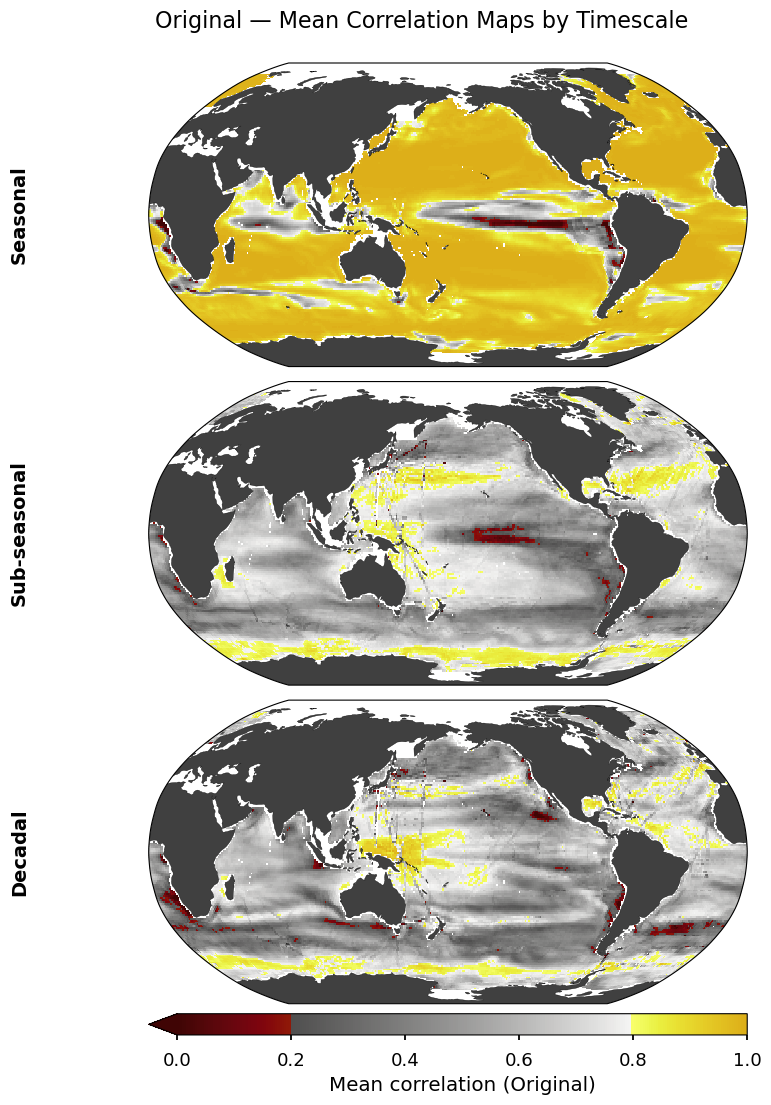

/tmp/ipykernel_10482/527810652.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


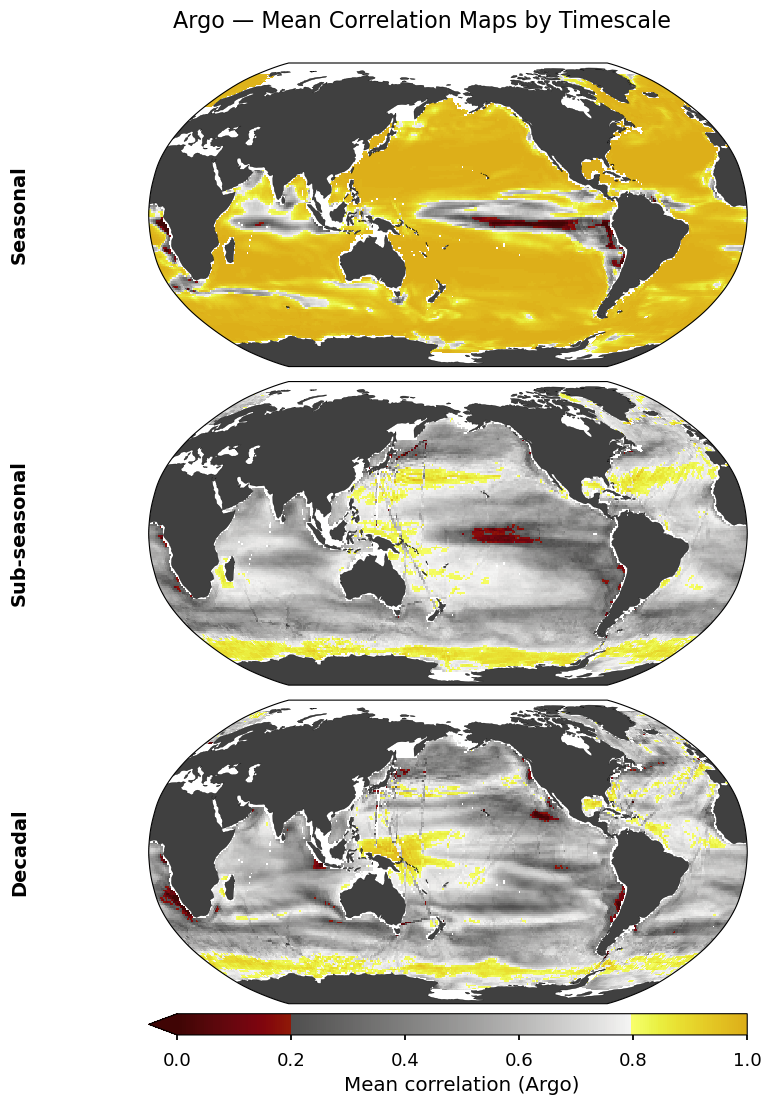

/tmp/ipykernel_10482/527810652.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


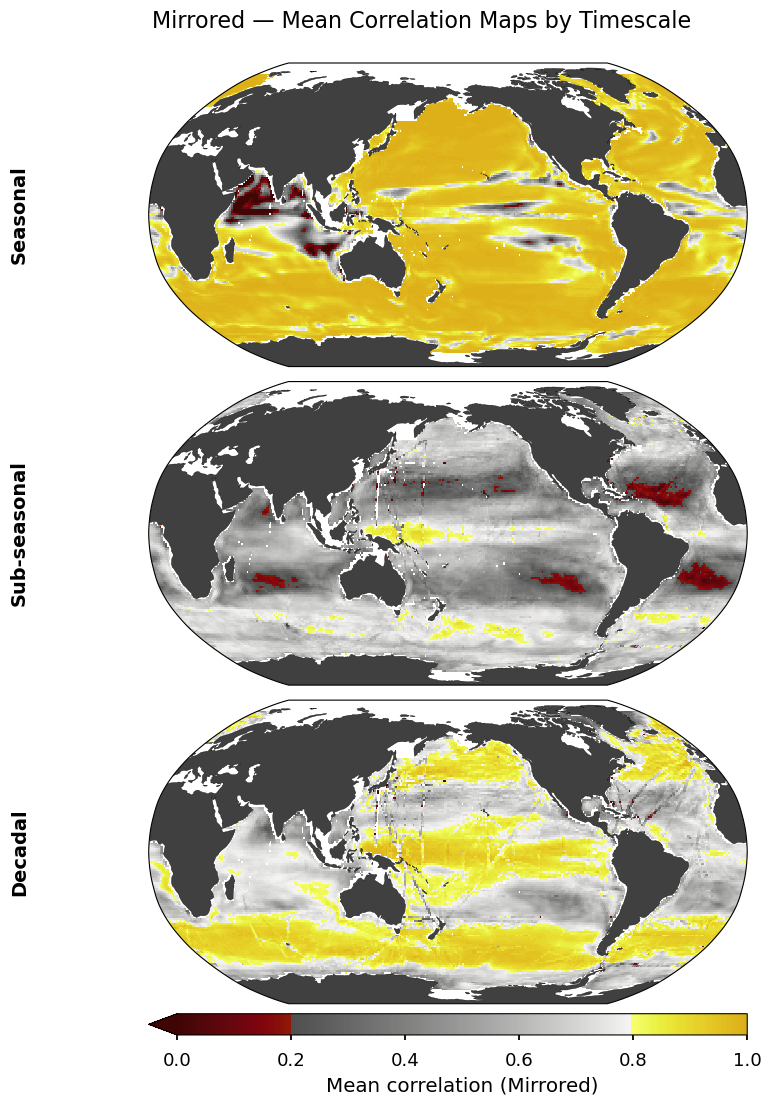

In [60]:
plot_correlation_trisection(ds_eval_corr, 'Original')
plot_correlation_trisection(argo_ds_eval_corr, 'Argo')
plot_correlation_trisection(mir_ds_eval_corr, 'Mirrored')

Fig. 13: Correlation between the original model and the reconstructions produced by the original model trained only on SOCAT data (top tri-section), the model trained on SOCAT data and Bio-Argo sampling locations (middle tri-section), and the model trained on SOCAT data and 30% of the northern hemisphere SOCAT data mirrored to the southern hemisphere (bottom tri-panel) for (a) seasonal, (b) sub-decadal, and (c) decadal time scales. Compared to the original model correlations, the Bio-Argo model shows the greatest improvements in correlation in the Southern Ocean for the sub-seasonal and decadal time series. Compared to the original model correlations, the mirrored model shows the greatest improvements in correlation across the entire Southern Hemisphere at the decadal (and seasonal to a lesser extent) time scale, and sees a slight decrease in correlation at the sub-seasonal scale in the same area. 

The findings of Figure 13 match the regions and timescales of the data added. 

Bio-Argo floats have been sampling since ~2008, meaning that they have been deployed for fewer than two decades and should not significantly improve pCO2 reconstructions on the decadal time scale. However, Bio-Argo floats collect samples from the ocean every 10 days, so it makes sense that Bio-Argo data would make improvements at the seasonal and sub-seasonal time scales. We only included the Bio-Argo data collected south of 35 degrees of latitude, so it also makes sense that improvements should be shown in the Southern Hemisphere. 

Conversely, we added data to the mirrored mask irrespective of time, across the entire Southern Hemisphere, to represent increased ship-based sampling methods. Because these data points were added since the 1980s, we see improvements at the seasonal and decadal time scales. Only individual samples were added, however, not multiple samples in the same region during the same time period, so it is understandable that improvements were not made at the sub-seasonal time scale. Data was added across the Southern Hemisphere, so it makes sense that the improvements observed are more widespread compared to the improvements observed in the Bio-Argo model run. 

While figure 13 gives us a lot of detail, especially regarding the timescale of improvement, it's a little hard to draw comparisons across nine panels. Let's just look at where (spatially) each model makes improvements, and let's use a boxplot so that we can compare everything in one plot. 

In [61]:
#Plot the tri-section plot for the ML output of all different masks 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Function to calculate regional mean bias from any ds_eval
def compute_regional_mean_bias(ds_eval, method_name):
    regional_mean_bias = []
    for region_name in ['>35°N', '35°S-35°N', '<35°S']:
        # Create mask for the current region
        if region_name == '>35°N':
            region_mask = ds_eval['ylat'] > 35
        elif region_name == '<35°S':
            region_mask = ds_eval['ylat'] < -35
        else:
            region_mask = (ds_eval['ylat'] >= -35) & (ds_eval['ylat'] <= 35)

        # Compute regional mean (mean over lat/lon/time)
        regional_mean = ds_eval['bias'].where(region_mask, drop=True).mean(dim=['ylat', 'xlon', 'time'])

        for en in ds_eval['ens'].values:
            for mem in ds_eval['member'].values:
                bias_value = regional_mean.sel(ens=en, member=mem).compute().item()
                regional_mean_bias.append({
                    'region': region_name,
                    'bias': bias_value,
                    'ens': en,
                    'member': mem,
                    'method': method_name
                })
    return pd.DataFrame(regional_mean_bias)

# 2. Compute for all datasets
dfs = []
dfs.append(compute_regional_mean_bias(mir_ds_eval, 'Mirrored'))
dfs.append(compute_regional_mean_bias(ds_eval, 'Original'))
dfs.append(compute_regional_mean_bias(ds_eval_argo, 'Argo'))

# 3. Combine all into a single DataFrame
df_all = pd.concat(dfs, ignore_index=True)

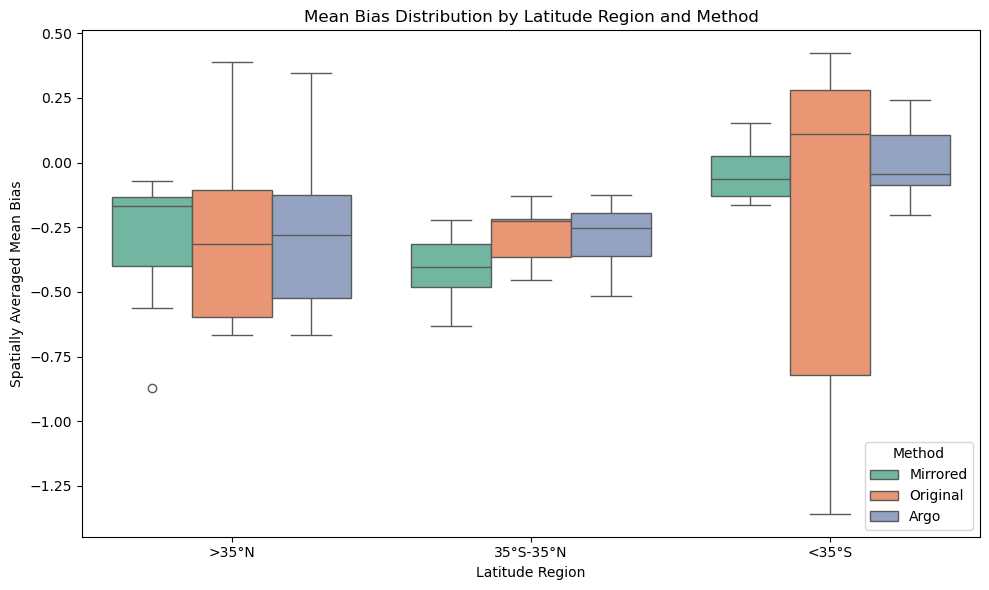

In [62]:
# 4. Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='region', 
    y='bias', 
    hue='method',
    data=df_all, 
    order=['>35°N', '35°S-35°N', '<35°S'],
    palette='Set2'
)
plt.title('Mean Bias Distribution by Latitude Region and Method')
plt.xlabel('Latitude Region')
plt.ylabel('Spatially Averaged Mean Bias')
plt.legend(title='Method', loc='lower right')
plt.tight_layout()
plt.show()

Fig. 14. Spatially averaged mean bias by latitude region for the original (orange), Bio-Argo (purple) and mirrored (green) experiments. Middle horizontal lines of the boxplots represent the median, upper and lower box boundaries contain the middle 50% of the data (interquartile range), and the upper and lower vertical lines contain 1.5 times the interquartile range.

The results of figure 14 tell a story similar to figure 13, but in a more concise, bias-oriented (rather than correlation-oriented) way. We see that all three models have very similar biases in the >35N and 35N-35S latitude regions, which makes sense because neither of the new masks added much (if any) data in the Northern Hemisphere. In the Southern Ocean, however, both new masks do an excellent job of constraining the variance in bias. Further, the realistic Bio-Argo sampling mask does a better job in reducing bias (closer to 0) compared to the hypothetical mirroring sampling mask!

# 3 Resample the most bias regions
In addition to the two methods discussed above, we also want to resample in the areas with the greatest bias to see if we can improve the ocean reconstruction results with fewer samples.
## Setup Workspace

In [19]:
your_username = 'Ft1923'  
owner_username = 'Ft1923'

In [20]:
grid_search_approach = 'nmse'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"

## 3.1 Original Model Bias 

In [21]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

<xarray.Dataset> Size: 3GB
Dimensions:      (member: 8, xlon: 360, ylat: 180, time: 240, ens: 3)
Coordinates:
  * member       (member) object 64B 'member_r10i1p1f1' ... 'member_r5i1p1f1'
  * xlon         (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat         (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * ens          (ens) object 24B 'ACCESS-ESM1-5' 'CanESM5' 'MPI-ESM1-2-LR'
Data variables:
    bias         (ens, member, time, ylat, xlon) float64 3GB dask.array<chunksize=(1, 1, 100, 45, 90), meta=np.ndarray>
    rmse         (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>
    correlation  (ens, member, ylat, xlon) float64 12MB dask.array<chunksize=(1, 1, 45, 90), meta=np.ndarray>


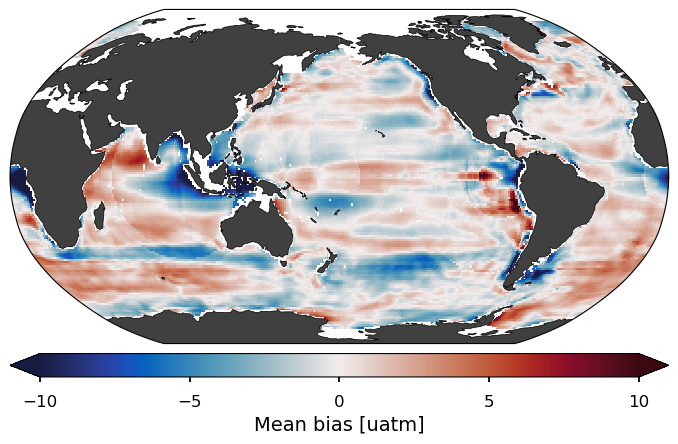

In [22]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

Fig. 15: A global map that visualizes the mean bias of the original model.

*Next, we will resample in areas where the absolute value of bias is greater than 3 uatm.*
## 3.2 Filter out the most biased locations
### Create a mean bias dataset
First, we created a dataset of the average bias of the original data, which would facilitate our data screening

In [23]:
# Calculate mean bias data
mean_bias_data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')

# Create new dataset
mean_bias_ds = xr.Dataset(
    data_vars={
        'bias': (('ylat', 'xlon'), mean_bias_data.values)
    },
    coords={
        'ylat': mean_bias_data.ylat,
        'xlon': mean_bias_data.xlon
    },
    attrs={
        'description': 'Mean bias dataset',
        'units': 'uatm',
        'created': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
)

# Print dataset information to check results
print(mean_bias_ds)

<xarray.Dataset> Size: 523kB
Dimensions:  (ylat: 180, xlon: 360)
Coordinates:
  * ylat     (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    bias     (ylat, xlon) float64 518kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Mean bias dataset
    units:        uatm
    created:      2025-04-29


### Select the most bias region data
Next, we start to select the data. To avoid the sampling being overly concentrated in some severely distorted areas, we do not use the top 1% and bottom 1% of the data. We choose the data from the 1% to 4% range at the top and from the 1% to 4% range at the bottom, which are the intervals with the largest positive and negative bia values.

In [24]:
# Get the original mean bias data
mean_bias_data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')

# Calculate needed thresholds
lower1_threshold = mean_bias_data.quantile(0.01, skipna=True)
lower4_threshold = mean_bias_data.quantile(0.04, skipna=True)
upper96_threshold = mean_bias_data.quantile(0.96, skipna=True)
upper99_threshold = mean_bias_data.quantile(0.99, skipna=True)

# Print thresholds for reference
print(f"Lower threshold (1st percentile): {lower1_threshold.values}")
print(f"Lower threshold (4th percentile): {lower4_threshold.values}")
print(f"Upper threshold (96th percentile): {upper96_threshold.values}")
print(f"Upper threshold (99th percentile): {upper99_threshold.values}")

# Create interval range masks
moderate_low_mask = (mean_bias_data > lower1_threshold) & (mean_bias_data <= lower4_threshold)
moderate_high_mask = (mean_bias_data >= upper96_threshold) & (mean_bias_data < upper99_threshold)

# Create a new dataset containing categorized values
extreme_bias_ds = xr.Dataset(
    data_vars={
        'bias': (('ylat', 'xlon'), mean_bias_data.values),
        'moderate_low': (('ylat', 'xlon'), moderate_low_mask.values),
        'moderate_high': (('ylat', 'xlon'), moderate_high_mask.values)
    },
    coords={
        'ylat': mean_bias_data.ylat,
        'xlon': mean_bias_data.xlon
    },
    attrs={
        'description': 'Bias values dataset for 1-4% and 96-99% ranges',
        'units': 'uatm',
        'lower1_threshold': float(lower1_threshold.values),
        'lower4_threshold': float(lower4_threshold.values),
        'upper96_threshold': float(upper96_threshold.values),
        'upper99_threshold': float(upper99_threshold.values),
        'created': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
)

# Print dataset information
print(extreme_bias_ds)

# Count the number of points in each category
num_moderate_low = extreme_bias_ds.moderate_low.sum().values
num_moderate_high = extreme_bias_ds.moderate_high.sum().values
total_categorized = num_moderate_low + num_moderate_high

print(f"Number of moderate low values (1-4%): {num_moderate_low}")
print(f"Number of moderate high values (96-99%): {num_moderate_high}")
print(f"Total number of categorized values: {total_categorized}")

Lower threshold (1st percentile): -9.060503204194863
Lower threshold (4th percentile): -5.058778536851677
Upper threshold (96th percentile): 3.515896443960671
Upper threshold (99th percentile): 5.171207636995523
<xarray.Dataset> Size: 652kB
Dimensions:        (ylat: 180, xlon: 360)
Coordinates:
  * ylat           (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * xlon           (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    bias           (ylat, xlon) float64 518kB nan nan nan nan ... nan nan nan
    moderate_low   (ylat, xlon) bool 65kB False False False ... False False
    moderate_high  (ylat, xlon) bool 65kB False False False ... False False
Attributes:
    description:        Bias values dataset for 1-4% and 96-99% ranges
    units:              uatm
    lower1_threshold:   -9.060503204194863
    lower4_threshold:   -5.058778536851677
    upper96_threshold:  3.515896443960671
    upper99_threshold:  5.171207636995523
    created:  

### Select region below 35°S
After the sampling was completed, since our project focuses on the Southern Ocean, we chose to retain only the data points at 35 degrees south latitude and below.

In [25]:
# Create a temporary copy of the original dataset
temp_ds = extreme_bias_ds.copy(deep=True)

# Filter to only include points at or below 35°S
southern_lat_mask = extreme_bias_ds.ylat <= -35  # Southern latitudes are negative
extreme_bias_ds = extreme_bias_ds.sel(ylat=southern_lat_mask)

# Print information about the filtered dataset
print(f"Original dataset dimensions: {temp_ds.dims}")
print(f"Filtered dataset dimensions: {extreme_bias_ds.dims}")

# Count how many moderate points are in the southern region
if 'moderate_low' in extreme_bias_ds:
    num_southern_low = extreme_bias_ds.moderate_low.sum().values
    print(f"Number of moderate low points (1-4%) at or below 35°S: {num_southern_low}")

if 'moderate_high' in extreme_bias_ds:
    num_southern_high = extreme_bias_ds.moderate_high.sum().values
    print(f"Number of moderate high points (96-99%) at or below 35°S: {num_southern_high}")

Original dataset dimensions: FrozenMappingWarningOnValuesAccess({'ylat': 180, 'xlon': 360})
Filtered dataset dimensions: FrozenMappingWarningOnValuesAccess({'ylat': 55, 'xlon': 360})
Number of moderate low points (1-4%) at or below 35°S: 391
Number of moderate high points (96-99%) at or below 35°S: 569


### Plot location of new dataset

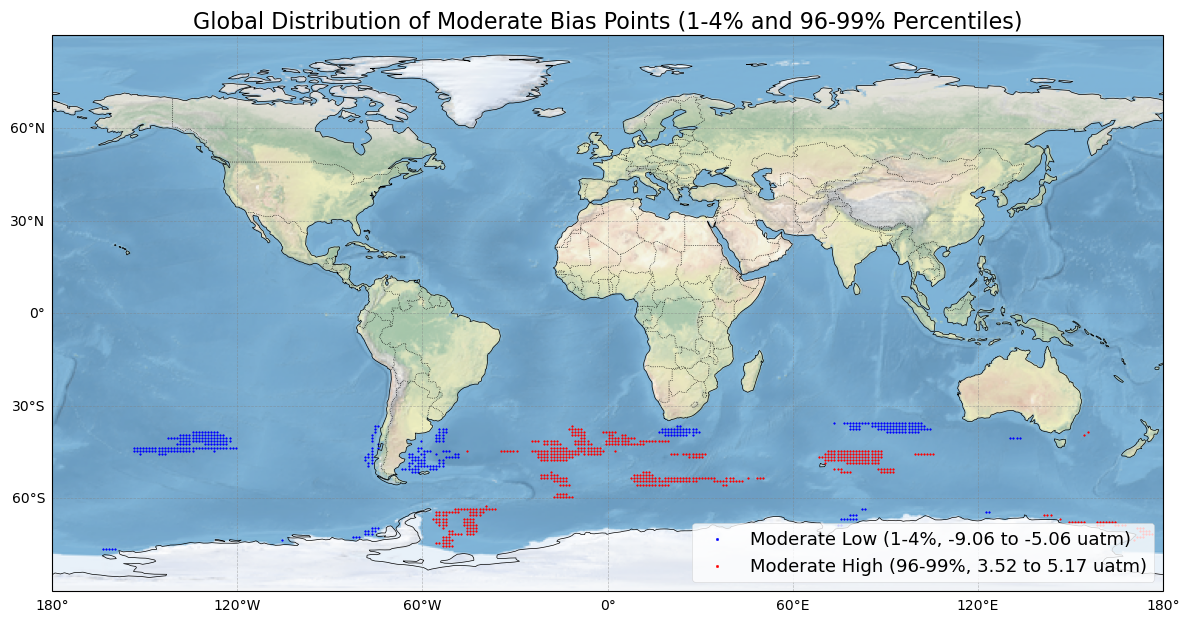

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get the data from extreme_bias_ds with the moderate ranges
# Extract coordinates for moderate low points (1-4%)
moderate_low_mask = extreme_bias_ds.moderate_low.values
low_ylats_idx, low_xlons_idx = np.where(moderate_low_mask)
low_ylats = extreme_bias_ds.ylat.values[low_ylats_idx]
low_xlons = extreme_bias_ds.xlon.values[low_xlons_idx]

# Extract coordinates for moderate high points (96-99%)
moderate_high_mask = extreme_bias_ds.moderate_high.values
high_ylats_idx, high_xlons_idx = np.where(moderate_high_mask)
high_ylats = extreme_bias_ds.ylat.values[high_ylats_idx]
high_xlons = extreme_bias_ds.xlon.values[high_xlons_idx]

# Create a pandas Series with MultiIndex for all moderate points
all_ylats = np.concatenate([low_ylats, high_ylats])
all_xlons = np.concatenate([low_xlons, high_xlons])

# Create categories to distinguish between low and high values
categories = np.concatenate([np.zeros(len(low_ylats)), np.ones(len(high_ylats))])
moderate_index = pd.MultiIndex.from_arrays([all_ylats, all_xlons], names=['ylat', 'xlon'])
moderate_points_indicator = pd.Series(categories, index=moderate_index, name='is_moderate_point')

# Get threshold values for labels
lower1_value = extreme_bias_ds.attrs['lower1_threshold']
lower4_value = extreme_bias_ds.attrs['lower4_threshold']
upper96_value = extreme_bias_ds.attrs['upper96_threshold']
upper99_value = extreme_bias_ds.attrs['upper99_threshold']

# Create the plot
plt.style.use('seaborn-v0_8-talk')
fig = plt.figure(figsize=(12, 8))

# Select map projection
projection = ccrs.PlateCarree(central_longitude=0)
ax = fig.add_subplot(1, 1, 1, projection=projection)

# Add map features
ax.set_global()
ax.stock_img()
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Plot moderate low points (1-4%)
ax.scatter(low_xlons, low_ylats,
          color='blue',
          s=5,
          marker='.',
          transform=ccrs.PlateCarree(),
          label=f'Moderate Low (1-4%, {lower1_value:.2f} to {lower4_value:.2f} uatm)'
         )

# Plot moderate high points (96-99%)
ax.scatter(high_xlons, high_ylats,
          color='red',
          s=5,
          marker='.',
          transform=ccrs.PlateCarree(),
          label=f'Moderate High (96-99%, {upper96_value:.2f} to {upper99_value:.2f} uatm)'
         )

# Add title
plt.title("Global Distribution of Moderate Bias Points (1-4% and 96-99% Percentiles)", fontsize=16)

# Add legend
plt.legend(markerscale=1.5, loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

Fig. 16: The global distribution map of the newly sampled points. As can be seen from the map, the sampling points are not concentrated in a region with a very large deviation. We believe that the range of this sampling is acceptable. Total adding points: 960
## 3.3 Create mask and merging dataset
In this part, we mask resampled data points and merge them with the socat dataset.

*The newly added sampling points are 960, which we randomly distribute among the 12 months of each year and then repeat the sampling annually to generate the dataset. In machine learning, we have 960 new locations and 19,200 new points.*

In [27]:
# Set random seed to ensure reproducibility
random.seed(42)
np.random.seed(42)

# --- Step 1: Extract points from extreme_bias_ds dataset and group them ---
print("--- Step 1: Extract points from dataset and randomly divide into 12 groups ---")

# Extract coordinates of moderate_low points
moderate_low_mask = extreme_bias_ds.moderate_low.values
low_ylats_idx, low_xlons_idx = np.where(moderate_low_mask)
low_ylats = extreme_bias_ds.ylat.values[low_ylats_idx]
low_xlons = extreme_bias_ds.xlon.values[low_xlons_idx]

# Extract coordinates of moderate_high points
moderate_high_mask = extreme_bias_ds.moderate_high.values
high_ylats_idx, high_xlons_idx = np.where(moderate_high_mask)
high_ylats = extreme_bias_ds.ylat.values[high_ylats_idx]
high_xlons = extreme_bias_ds.xlon.values[high_xlons_idx]

# Combine coordinates of all points
all_ylats = np.concatenate([low_ylats, high_ylats])
all_xlons = np.concatenate([low_xlons, high_xlons])

# Create list of points, each containing (latitude, longitude)
points = list(zip(all_ylats, all_xlons))
# Calculate the total number of points
total_points = len(points)
print(f"Total extracted points: {total_points} ({len(low_ylats)} low value points and {len(high_ylats)} high value points)")

# Randomly shuffle the points
random.shuffle(points)

# Divide points into 12 groups
points_per_group = total_points // 12
remainder = total_points % 12
point_groups = []

start_idx = 0
for i in range(12):
    # Allocate extra points to handle remainder
    extra = 1 if i < remainder else 0
    end_idx = start_idx + points_per_group + extra
    point_groups.append(points[start_idx:end_idx])
    start_idx = end_idx

# Print number of points in each group
for i, group in enumerate(point_groups):
    print(f"Group {i+1} (Month {i+1}): {len(group)} points")

# --- Step 2: Define time-space grid ---
print("\n--- Step 2: Define time-space grid ---")
time_start = "2004-01-01"
time_end = "2023-12-01"
time_freq = "MS"  # Month start
time_range = pd.date_range(time_start, time_end, freq=time_freq)

lat_start, lat_end, lat_step = -90, 90, 1.0
lat_bins = np.arange(lat_start + lat_step/2, lat_end + lat_step/2, lat_step)  # Grid center points

lon_start, lon_end, lon_step = 0, 360, 1.0
lon_bins = np.arange(lon_start + lon_step/2, lon_end + lon_step/2, lon_step)  # Grid center points

print(f"Time range: {time_range.min()} to {time_range.max()}, Frequency: {time_range.freqstr}")
print(f"Latitude grid ({len(lat_bins)} points): Min={lat_bins.min():.2f}, Max={lat_bins.max():.2f}, Step={lat_step}")
print(f"Longitude grid ({len(lon_bins)} points): Min={lon_bins.min():.2f}, Max={lon_bins.max():.2f}, Step={lon_step}")

# --- Step 3: Create time-space mask ---
print("\n--- Step 3: Create time-space mask ---")

# Initialize 3D array with dimensions time × latitude × longitude
num_timesteps = len(time_range)
extreme_mask_3d = np.zeros((num_timesteps, len(lat_bins), len(lon_bins)), dtype=np.int8)

# For each time point, apply the corresponding month's group
for t in range(num_timesteps):
    # Get the month of current time point (1-12)
    month = time_range[t].month
    # Get corresponding month's point group (month starts at 1, index starts at 0)
    group = point_groups[month-1]
    
    # Process each point in the group
    for lat, lon in group:
        # Find nearest latitude index
        y_idx = np.argmin(np.abs(lat_bins - lat))
        
        # Find nearest longitude index (handle 0/360 cycle)
        lon_norm = lon % 360
        delta_lon = np.abs(lon_bins - lon_norm)
        delta_lon_wrapped = np.minimum(delta_lon, 360.0 - delta_lon)
        x_idx = np.argmin(delta_lon_wrapped)
        
        # Mark this point in the mask, all points use value 1
        extreme_mask_3d[t, y_idx, x_idx] = 1

# --- Step 4: Convert to xarray DataArray ---
print("\n--- Step 4: Convert to xarray DataArray ---")
extreme_points_mask_data = xr.DataArray(
    extreme_mask_3d,
    dims=["time", "ylat", "xlon"],
    coords={
        "time": time_range,
        "ylat": lat_bins,
        "xlon": lon_bins
    },
    name="extreme_point_mask"
)

# Create xarray dataset
extreme_points_mask_ds = xr.Dataset({
    "extreme_point_mask": extreme_points_mask_data
})

# Add dataset attributes
extreme_points_mask_ds.attrs = {
    "description": "Time-space mask marking extreme bias points",
    "creation_date": pd.Timestamp.now().strftime("%Y-%m-%d"),
    "points_distribution": "Monthly random allocation",
    "random_seed": 42,
    "total_points": total_points,
    "moderate_low_points": len(low_ylats),
    "moderate_high_points": len(high_ylats),
    "mask_value": "1 = extreme point exists"
}

# --- Step 5: Result summary ---
print("\n--- Step 5: Result summary ---")
print("Dataset structure:")
print(extreme_points_mask_ds)

print("\nMask summary:")
print(f"Shape: {extreme_points_mask_data.shape}")

# Calculate occurrence count of each value
value_counts = np.bincount(extreme_mask_3d.flatten(), minlength=2)
print(f"Value distribution: 0 (no point): {value_counts[0]}, 1 (has point): {value_counts[1]}")

# Distribution by year is the same because we cycle by month
year_counts = []
for year in range(2004, 2024):
    if year == 2023:
        months_in_year = 12  # 2023 has all 12 months
    else:
        months_in_year = 12
    
    year_mask = (time_range.year == year)
    year_data = extreme_mask_3d[year_mask, :, :]
    year_counts.append((year, np.sum(year_data > 0)))

print("\nPoints marked each year:")
for year, count in year_counts:
    print(f"{year}: {count} points")

--- Step 1: Extract points from dataset and randomly divide into 12 groups ---
Total extracted points: 960 (391 low value points and 569 high value points)
Group 1 (Month 1): 80 points
Group 2 (Month 2): 80 points
Group 3 (Month 3): 80 points
Group 4 (Month 4): 80 points
Group 5 (Month 5): 80 points
Group 6 (Month 6): 80 points
Group 7 (Month 7): 80 points
Group 8 (Month 8): 80 points
Group 9 (Month 9): 80 points
Group 10 (Month 10): 80 points
Group 11 (Month 11): 80 points
Group 12 (Month 12): 80 points

--- Step 2: Define time-space grid ---
Time range: 2004-01-01 00:00:00 to 2023-12-01 00:00:00, Frequency: MS
Latitude grid (180 points): Min=-89.50, Max=89.50, Step=1.0
Longitude grid (360 points): Min=0.50, Max=359.50, Step=1.0

--- Step 3: Create time-space mask ---

--- Step 4: Convert to xarray DataArray ---

--- Step 5: Result summary ---
Dataset structure:
<xarray.Dataset> Size: 16MB
Dimensions:             (time: 240, ylat: 180, xlon: 360)
Coordinates:
  * time                (

In [29]:
extreme_points_mask_ds["xlon"] = extreme_points_mask_ds["xlon"] -180
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

# Step 1: Extract the required DataArrays from the Datasets
try:
    socat_mask = socat_mask_data['socat_mask']
    print("  Successfully extracted 'socat_mask'")
except NameError:
    print("  Error: Variable 'socat_mask_data' does not exist. Please ensure it is loaded.")
    raise # Raise error to stop execution
except KeyError:
    print("  Error: Variable named 'socat_mask' not found in 'socat_mask_data' Dataset.")
    raise # Raise error to stop execution

try:
    # Note: When previously created, the DataArray name was 'extreme_point_mask'
    extreme_mask = extreme_points_mask_ds['extreme_point_mask']
    print("  Successfully extracted 'extreme_point_mask'")
except NameError:
    print("  Error: Variable 'extreme_points_mask_ds' does not exist. Please ensure it has been created.")
    raise # Raise error to stop execution
except KeyError:
    print("  Error: Variable named 'extreme_point_mask' not found in 'extreme_points_mask_ds' Dataset.")
    raise # Raise error to stop execution

# Step 2: Check if dimensions match (Optional but recommended)
if socat_mask.shape != extreme_mask.shape:
    print(f"  Warning: Input mask dimensions do not match! socat_mask={socat_mask.shape}, extreme_mask={extreme_mask.shape}")
    print("  Please check if grid definitions are consistent. Code will attempt to continue, but the result might be incorrect.")
    # You might want to stop execution here: raise ValueError("Input mask dimensions do not match")

# Step 3: Create boolean condition representing area south of 35°S
# (Can use coordinates from either mask, e.g., socat_mask)
southern_hemisphere = socat_mask['ylat'] < -35
print("  Defined condition: Latitude < -35 S")

# Step 4: Apply conditional merge logic using xr.where
print("  Applying conditional merging logic...")
combined_mask_data = xr.where(
    southern_hemisphere,                         # Condition: Latitude < -35°S
    (socat_mask == 1) | (extreme_mask == 1), # When condition is True (South): Result is 1 if socat is 1 OR extreme is 1
    socat_mask == 1                              # When condition is False (North): Result is 1 if socat is 1
).astype(np.int8)                                # Convert boolean result (True/False) to integer (1/0), use int8 to maintain type consistency

# Step 5: Name the newly generated DataArray
combined_mask_data.name = 'socat_extreme_mask' # Give the combined mask a new name
print("  Combined mask calculation complete.")

# Step 6: Create a new Xarray Dataset to store the combined mask
# (Use new Dataset name and internal variable name to avoid confusion)
socat_extreme_mask_ds = xr.Dataset(
    {combined_mask_data.name: combined_mask_data}, # Internal Dataset variable name uses the DataArray's name
    coords=socat_mask.coords                      # Copy coordinate information from one of the inputs
    )
print("  Created new Dataset 'socat_extreme_mask_ds'")

# Step 7: Print the resulting Dataset for inspection
print("\n--- Result ---")
print(socat_extreme_mask_ds)

  Successfully extracted 'socat_mask'
  Successfully extracted 'extreme_point_mask'
  Defined condition: Latitude < -35 S
  Applying conditional merging logic...
  Combined mask calculation complete.
  Created new Dataset 'socat_extreme_mask_ds'

--- Result ---
<xarray.Dataset> Size: 16MB
Dimensions:             (ylat: 180, time: 240, xlon: 360)
Coordinates:
  * ylat                (ylat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                (time) datetime64[ns] 2kB 2004-01-01 ... 2023-12-01
  * xlon                (xlon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    socat_extreme_mask  (ylat, time, xlon) int8 16MB dask.array<chunksize=(45, 52, 90), meta=np.ndarray>


### Plot merging mask dataset

Data shape: (180, 360)


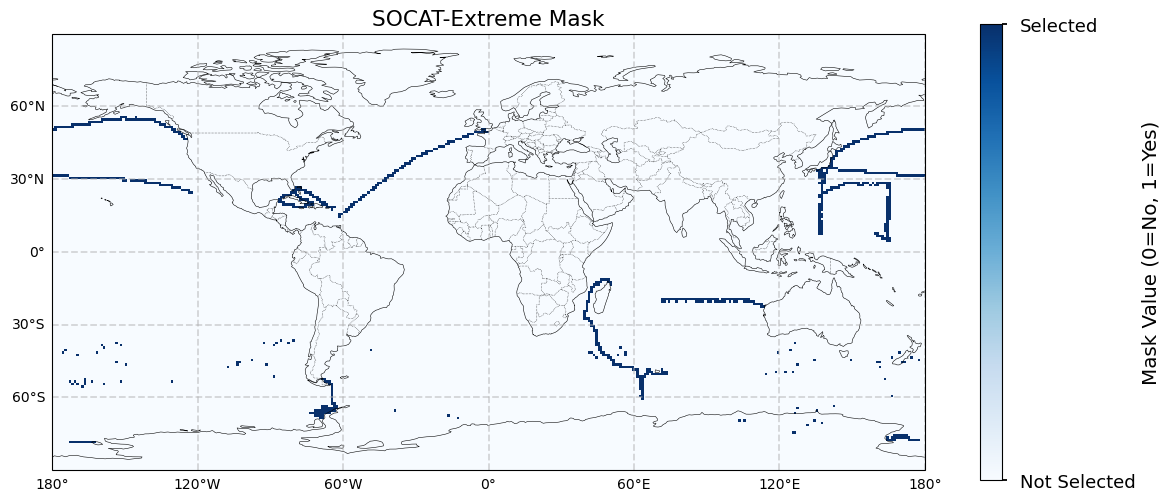

In [30]:
if ('socat_extreme_mask_ds' in locals() and 
    isinstance(socat_extreme_mask_ds, xr.Dataset) and
    'socat_extreme_mask' in socat_extreme_mask_ds):
    
    # Get the mask array and check first time step
    mask = socat_extreme_mask_ds['socat_extreme_mask'].isel(time=0)
    
    # Check if mask has any values == 1
    if np.any(mask.values == 1):
        print(f"Data shape: {mask.shape}")
        
        # Create plot
        plt.figure(figsize=(12, 6))
        ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.set_global()
        
        # Plot the mask
        plot_mesh = mask.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap='Blues',
            vmin=0, vmax=1,
            add_colorbar=False
        )
        
        # Add colorbar and features
        cbar = plt.colorbar(plot_mesh, ticks=[0, 1], shrink=0.8)
        cbar.set_label('Mask Value (0=No, 1=Yes)')
        cbar.ax.set_yticklabels(['Not Selected', 'Selected'])
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        
        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
        gl.top_labels = gl.right_labels = False
        
        plt.title("SOCAT-Extreme Mask")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Mask contains no values == 1. Nothing to plot.")
else:
    print("Error: Valid mask data not found.")

Fig. 17: Mask distribution of the merged dataset. Time selected: January 2004.

## 3.4 Evaluation and Reconstruction Visualization

### loading `calc_recon_pco2bias` function

In [31]:
def calc_recon_pco2bias(regridded_members_dir, pco2_recon_dir, selected_mems_dict, init_date, fin_date, owner_name=None):

    init_date_sel= pd.to_datetime(init_date, format="%Y%m")
    fin_date_sel = pd.to_datetime(fin_date, format="%Y%m")

    # --- Owner Logic ---
    if owner_name:
        print("Reviewing process: Running ML only for the first member of the first ESM, loading remaining reconstructed data from the notebook owner (EXTREME version).")
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
        grid_search_approach = 'nmse'
        owner_output_dir = f'gs://leap-persistent/{owner_name}/{owner_name}/pco2_residual/{grid_search_approach}/post02_xgb' 
        owner_recon_output_dir = f"{owner_output_dir}/reconstructions_extreme1pct"
    else:
        run_selected_mems_dict = selected_mems_dict

    fs = fsspec.filesystem('gs')

    for ens, mem_list in run_selected_mems_dict.items():
        print(f"Current ESM: {ens}")

        ens_extreme = ens + "_extreme1pct" 

        for member in mem_list:
            print(f"On member {member}")

            pco2T_path = f'{regridded_members_dir}/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
            print('pco2T path:',pco2T_path)

            pCO2R_path = f"{pco2_recon_dir}/{ens_extreme}/{member}/recon_pCO2residual_{ens_extreme}_{member}_mon_1x1_{init_date}_{fin_date}.zarr" # <--- MODIFIED: 使用 ens_extreme 和传入的目录参数
            print('pCO2R path:', pCO2R_path) 

            ### Path to save calculated pCO2 
            file_out = f"{pco2_recon_dir}/{ens_extreme}/{member}/recon_pCO2_{ens_extreme}_{member}_mon_1x1_{init_date}_{fin_date}.zarr" # <--- MODIFIED: 使用 ens_extreme 和传入的目录参数
            print('save path:', file_out) 

            try:
                ### Loading pCO2-T and reconstructed pCO2-residual (from extreme Zarr):
                print(f"  Loading pco2T_series from: {pco2T_path}")
                pco2T_series = xr.open_zarr(pco2T_path).pco2_T.transpose("time","ylat","xlon").sel(time=slice(init_date_sel, fin_date_sel))

                print(f"  Loading pco2_ml_output (contains residuals) from: {pCO2R_path}")
                pco2_ml_output = xr.open_zarr(pCO2R_path)

                ### Extracting residual fields
                pCO2R_unseen_series = pco2_ml_output.pCO2_recon_unseen.transpose("time","ylat","xlon")
                pCO2R_full_series = pco2_ml_output.pCO2_recon_full.transpose("time","ylat","xlon")
                if 'pCO2_truth' in pco2_ml_output:
                     pCO2R_truth = pco2_ml_output.pCO2_truth.transpose("time","ylat","xlon")
                else:
                     pCO2R_truth = None

                ### Time Alignment 
                print("  Aligning time coordinates...")
                pco2T_series = pco2T_series.assign_coords({"time":("time", pCO2R_unseen_series.time.data)})

                ### Total pCO2 Calculation 
                print("  Calculating final pCO2 fields...")
                pco2_unseen = pco2T_series + pCO2R_unseen_series
                pco2_full =  pco2T_series + pCO2R_full_series
                if pCO2R_truth is not None:
                    pco2_truth_final = pco2T_series + pCO2R_truth
                else:
                    pco2_truth_final = None

                ### Creating output Dataset 
                print("  Creating output dataset...")
                output_data_vars = {
                    'pCO2_recon_unseen': (["time", "ylat", "xlon"], pco2_unseen.data),
                    'pCO2_recon_full': (["time", "ylat", "xlon"], pco2_full.data)
                }
                if pco2_truth_final is not None:
                    output_data_vars['pCO2_truth'] = (["time", "ylat", "xlon"], pco2_truth_final.data)
                elif 'pCO2_truth' in pco2T_series.coords or 'pCO2_truth' in pco2T_series:
                     output_data_vars['pCO2_truth'] = pco2T_series['pCO2_truth']

                comp = xr.Dataset(
                    output_data_vars,
                    coords={'time': (['time'], pco2T_series.time.values),
                            'xlon': (['xlon'], pco2T_series.xlon.values),
                            'ylat': (['ylat'], pco2T_series.ylat.values)}
                )

                ### Saving Logic 
                if fs.exists(file_out):
                    print(f"  Output file exists, removing: {file_out}")
                    fs.rm(file_out, recursive=True)

                print(f"  Saving final reconstructed pCO2 to: {file_out}")
                comp = comp.chunk({'time':100,'ylat':45,'xlon':90})
                comp.to_zarr(file_out, mode='w', consolidated=True)

                print(f'finished with {member}')

            except FileNotFoundError:
                print(f"  Error: Input file not found for member {member}.")
                print(f"  Tried pco2T path: {pco2T_path}")
                print(f"  Tried pCO2R path: {pCO2R_path}") 
                print(f"  Skipping this member.")
                continue
            except Exception as e:
                print(f"  An unexpected error occurred for member {member}: {e}")
                print(f"  Skipping this member.")
                continue

    # --- Owner Copying Logic ---
    if owner_name:
        print("Copying remaining members from owner’s directory (EXTREME version)...")
        for ens, mem_list in selected_mems_dict.items():
            owner_ens_extreme = ens + "_extreme1pct" # <--- MODIFIED
            target_ens_extreme = ens + "_extreme1pct" # <--- ADDED 

            if ens in run_selected_mems_dict:
                remaining_members = [m for m in mem_list if m not in run_selected_mems_dict[ens]]
            else:
                remaining_members = mem_list

            for member in remaining_members:
                print(f"Checking owner data for {ens}/{member}")
                owner_file_out = f"{owner_recon_output_dir}/{owner_ens_extreme}/{member}/recon_pCO2_{owner_ens_extreme}_{member}_mon_1x1_{init_date}_{fin_date}.zarr" # <--- MODIFIED
                target_file_out = f"{pco2_recon_dir}/{target_ens_extreme}/{member}/recon_pCO2_{target_ens_extreme}_{member}_mon_1x1_{init_date}_{fin_date}.zarr" # <--- MODIFIED

                if fs.exists(owner_file_out):
                    print(f"Copying {owner_file_out} → {target_file_out}")
                    target_dir = os.path.dirname(target_file_out)
                    if not fs.exists(target_dir):
                         fs.mkdirs(target_dir, exist_ok=True)
                    fs.copy(owner_file_out, target_file_out, recursive=True)
                    print(f'Finished copying for {member}')
                else:
                    print(f"Warning: Owner file {owner_file_out} not found. Skipping copy for {member}.")

Visualization object: Ensemble=ACCESS-ESM1-5, Member=member_r10i1p1f1
Loading original data: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Loading extreme point reconstruction results: gs://leap-persistent/Ft1923/Ft1923/pco2_residual/nmse/post02_xgb/reconstructions_extreme1pct/ACCESS-ESM1-5_extreme1pct/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_extreme1pct_member_r10i1p1f1_mon_1x1_200401_202312.zarr
Selecting time slice: 2021-01
Adjusting longitude...
Loading and applying extreme point mask...
Original data has been masked using extreme point mask.
Generating plot...


/tmp/ipykernel_222/2859390099.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


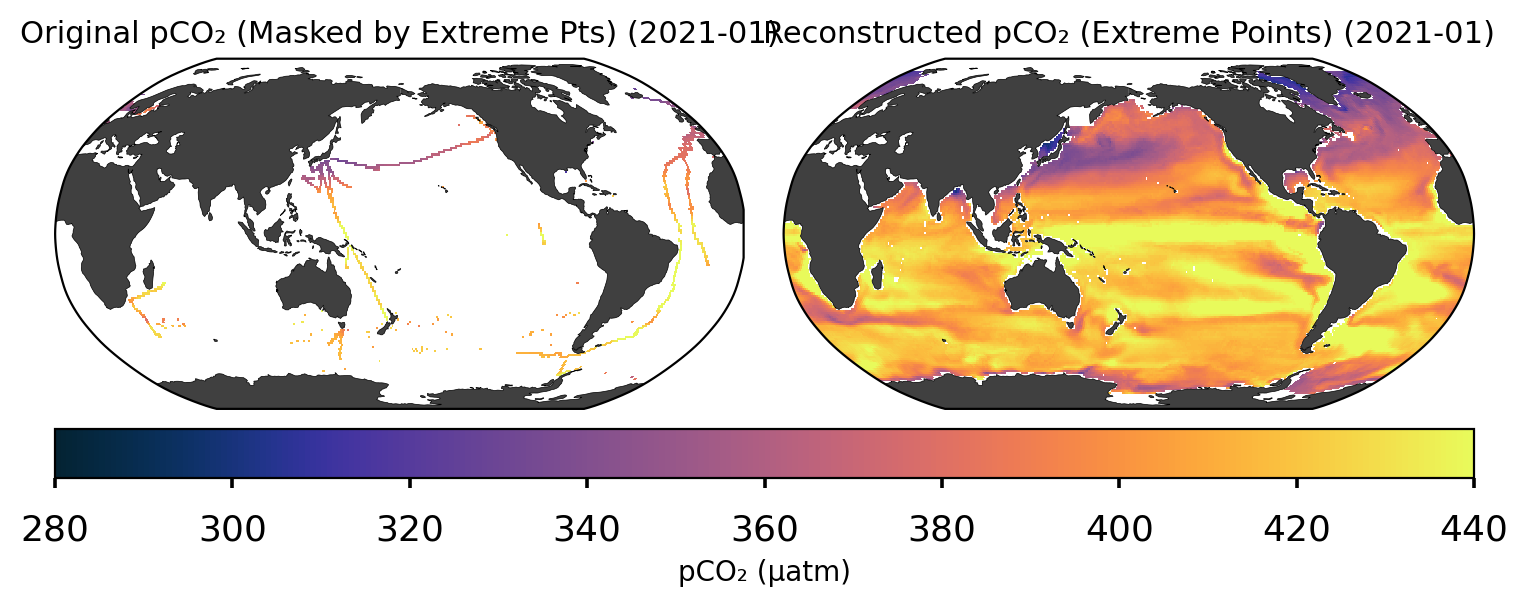

Fig 17: Visualize the bias reconstruction for 1 month


In [33]:
import fsspec

recon_output_dir = f"{output_dir}/reconstructions_extreme1pct" # where to save extreme ML reconstructions
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]

try:
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]
    print(f"Visualization object: Ensemble={first_ens}, Member={first_mem}")
except Exception as e:
    print(f"Error: Failed to select ensemble/member: {e}. Please ensure 'selected_mems_dict' is valid.")
    raise

try:
    member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
    member_paths = fs.glob(f"{member_dir}/*.zarr")
    if not member_paths:
        raise FileNotFoundError(f"No Zarr data found in {member_dir}")
    member_path = member_paths[0]
    print(f"Loading original data: gs://{member_path}")
    member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))
    if "spco2" not in member_data:
         raise KeyError("'spco2' variable not found in original member data")
except Exception as e:
    print(f"Error: Failed to load original member data: {e}")
    raise

try:
    recon_dir = f"{recon_output_dir}/{(first_ens + '_extreme1pct')}/{first_mem}"
    recon_path = f"{recon_dir}/recon_pCO2_{(first_ens + '_extreme1pct')}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    print(f"Loading extreme point reconstruction results: {recon_path}")
    if not fs.exists(recon_path):
         raise FileNotFoundError(f"Extreme point reconstruction file not found: {recon_path}")
    full_recon_ds = xr.open_zarr(recon_path, consolidated=True)
    if "pCO2_recon_full" not in full_recon_ds:
         raise KeyError(f"'pCO2_recon_full' not found in extreme point reconstruction file: {recon_path}")
    full = full_recon_ds["pCO2_recon_full"]
except Exception as e:
    print(f"Error: Failed to load extreme point reconstruction data: {e}")
    raise

chosen_time = '2021-01'
print(f"Selecting time slice: {chosen_time}")
try:
    raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
    if 'time' in full.coords and len(full.coords['time']) > 1 :
         recon_data = full.sel(time=chosen_time).squeeze()
    elif 'time' in full.coords and len(full.coords['time']) == 1 and pd.to_datetime(full.coords['time'].values[0]).strftime('%Y-%m') == chosen_time:
          recon_data = full.squeeze('time', drop=True)
    elif 'time' not in full.coords:
          recon_data = full
    else:
          raise ValueError(f"Unable to select time '{chosen_time}' from reconstruction data")

except Exception as e:
     print(f"Error: Failed to select time slice '{chosen_time}': {e}")
     raise

print("Adjusting longitude...")
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

print("Loading and applying extreme point mask...")
try:
    if 'extreme_points_mask_ds' not in locals():
        raise NameError("'extreme_points_mask_ds' Dataset not found.")
    if 'extreme_point_mask' not in extreme_points_mask_ds:
        raise KeyError("'extreme_point_mask' not found in extreme_points_mask_ds.")

    mask_data_array = socat_extreme_mask_ds['socat_extreme_mask']

    if 'time' in mask_data_array.coords:
        mask = mask_data_array.sel(time=chosen_time).squeeze()
    else:
        mask = mask_data_array.squeeze()

    mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

    masked_raw = np.ma.masked_array(raw_data.values, mask=(mask.values == 0))
    print("Original data has been masked using extreme point mask.")

except Exception as e:
    print(f"Warning: Error applying extreme point mask: {e}. Will plot unmasked original data.")
    masked_raw = raw_data.values

print("Generating plot...")
try:
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig, region='world',
            cbar_mode='single',
            colorbar=True,
            cbar_location='bottom',
            nrows_ncols=[1, 2]
        )

        sub0 = worldmap.add_plot(
            lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
            vrange=vrange, cmap=cmap, ax=0
        )
        sub1 = worldmap.add_plot(
            lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data.values,
            vrange=vrange, cmap=cmap, ax=1
        )

        worldmap.set_title(f"Original pCO₂ (Masked by Extreme Pts) ({chosen_time})", ax=0, fontsize=11)
        worldmap.set_title(f"Reconstructed pCO₂ (Extreme Points) ({chosen_time})", ax=1, fontsize=11)

        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=10)

        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()
    print("Fig 18: Visualize the bias reconstruction for 1 month")

except NameError as e:
     print(f"Plot error: Required libraries or classes (e.g. SpatialMap2) not found: {e}")
     print("Please ensure necessary visualization libraries are imported.")
except Exception as e:
     print(f"Error occurred during plotting: {e}")

## 3.5 Bias visualization
### Bias calculation
loading function

In [34]:
def concat_datasetsbias(mems_dict, recon_output_dir, init_date, fin_date):
    datasets_ens = []
    recon_output_dir_base = recon_output_dir.rstrip('/')
    
    for ens, mem_list in mems_dict.items():
        datasets_member = []
        ens_identifier = ens + "_extreme1pct"
        print(f"Using identifier to build path: {ens_identifier}")
        
        for n_member, member in enumerate(mem_list):
            recon_member_subdir = f"{recon_output_dir_base}/{ens_identifier}/{member}"
            recon_path = f"{recon_member_subdir}/recon_pCO2_{ens_identifier}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
            print(f"Attempting to load: {recon_path}")
            
            ds_recon_info = None
            try:
                kwargs = dict(chunks={'time':-1})
                ds_recon_info = xr.open_zarr(recon_path, consolidated=True)
                
                truth = ds_recon_info["pCO2_truth"]
                recon = ds_recon_info["pCO2_recon_unseen"]
                
                truth = truth.assign_coords(status='truth')
                recon = recon.assign_coords(status='reconstructed')
                
                common_time = np.intersect1d(truth['time'].values, recon['time'].values)
                truth = truth.sel(time=common_time)
                recon = recon.sel(time=common_time)
                
                member_ds = xr.concat([truth, recon], dim='status')
                member_ds = member_ds.expand_dims({"member": [member]})
                datasets_member.append(member_ds)
                
                ds_recon_info.close()
            
            except FileNotFoundError:
                print(f"Error: File not found {recon_path}. Skipping member {member}.")
                continue
            except KeyError as e:
                print(f"Error: Variable {e} not found in {recon_path}. Skipping member {member}.")
                if ds_recon_info: ds_recon_info.close()
                continue
            except Exception as e:
                print(f"Error: Unexpected error processing member {member}: {e}")
                traceback.print_exc()
                if ds_recon_info: ds_recon_info.close()
                continue
        
        if datasets_member:
            ds_ens = xr.concat(datasets_member, dim="member")
            ds_ens = ds_ens.expand_dims({"ens": [ens]})
            datasets_ens.append(ds_ens)
        else:
            print(f"Warning: Ensemble {ens} did not successfully process any members.")
    
    if not datasets_ens:
        print("Error: Unable to merge data from any ensemble.")
        return xr.Dataset()
    
    try:
        ds_concat = xr.concat(datasets_ens, dim='ens')
        return ds_concat
    except Exception as e:
        print(f"Error: Failed to concatenate ensembles: {e}")
        traceback.print_exc()
        return None

In [35]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasetsbias(mems_dict, recon_output_dir = recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_evalbias = evaluator.compute_all_metrics()
print(ds_evalbias)

Using identifier to build path: ACCESS-ESM1-5_extreme1pct
Attempting to load: gs://leap-persistent/Ft1923/Ft1923/pco2_residual/nmse/post02_xgb/reconstructions_extreme1pct/ACCESS-ESM1-5_extreme1pct/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_extreme1pct_member_r10i1p1f1_mon_1x1_200401_202312.zarr
Attempting to load: gs://leap-persistent/Ft1923/Ft1923/pco2_residual/nmse/post02_xgb/reconstructions_extreme1pct/ACCESS-ESM1-5_extreme1pct/member_r5i1p1f1/recon_pCO2_ACCESS-ESM1-5_extreme1pct_member_r5i1p1f1_mon_1x1_200401_202312.zarr
Attempting to load: gs://leap-persistent/Ft1923/Ft1923/pco2_residual/nmse/post02_xgb/reconstructions_extreme1pct/ACCESS-ESM1-5_extreme1pct/member_r2i1p1f1/recon_pCO2_ACCESS-ESM1-5_extreme1pct_member_r2i1p1f1_mon_1x1_200401_202312.zarr
Using identifier to build path: CanESM5_extreme1pct
Attempting to load: gs://leap-persistent/Ft1923/Ft1923/pco2_residual/nmse/post02_xgb/reconstructions_extreme1pct/CanESM5_extreme1pct/member_r2i1p1f1/recon_pCO2_CanESM5_extreme1pct_mem

#### Northern hemisphere bias

In [36]:
ds_eval_meanbias = (ds_evalbias['bias']*1).mean('ens').mean('time')
ds_eval_meanbias.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    95688.000000
mean        -0.425425
std          3.204413
min        -48.095065
25%         -1.709715
50%         -0.250058
75%          1.125310
max         20.563162
Name: bias, dtype: float64

#### Southern hemisphere bias

In [37]:
ds_eval_meanbias.sel(ylat=slice(-90,0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

count    172048.000000
mean          0.123623
std           3.579790
min         -46.942440
25%          -1.367481
50%           0.335015
75%           1.893104
max          68.804817
Name: bias, dtype: float64

### Global visualization

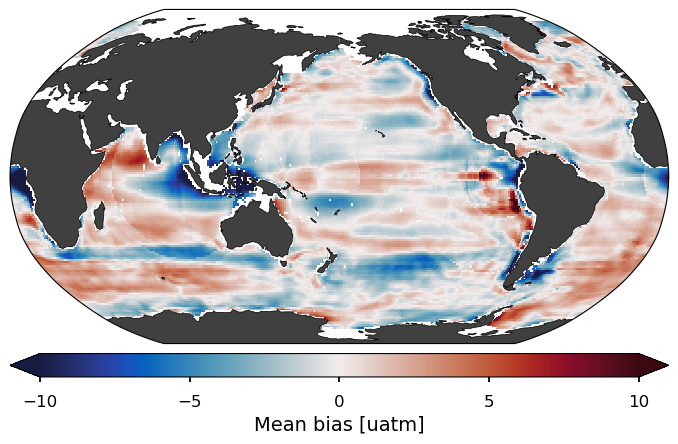

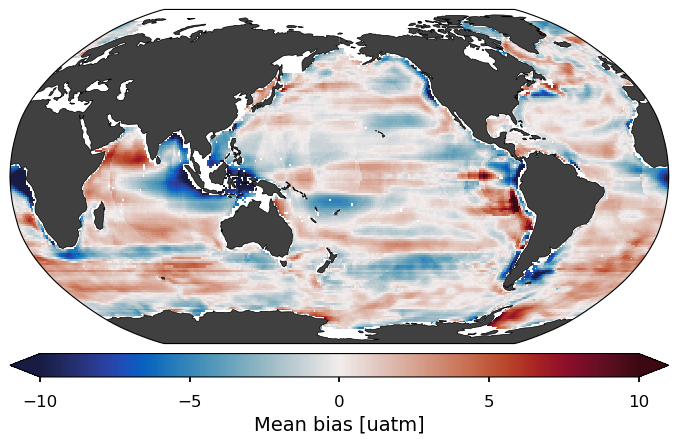

In [38]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_evalbias['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

Fig 19: Origin Bias versus Resample Global visualization of bias. As can be seen from the figure, the reconstruction effect in the southern ocean is quite good, especially in the areas with resampling points.

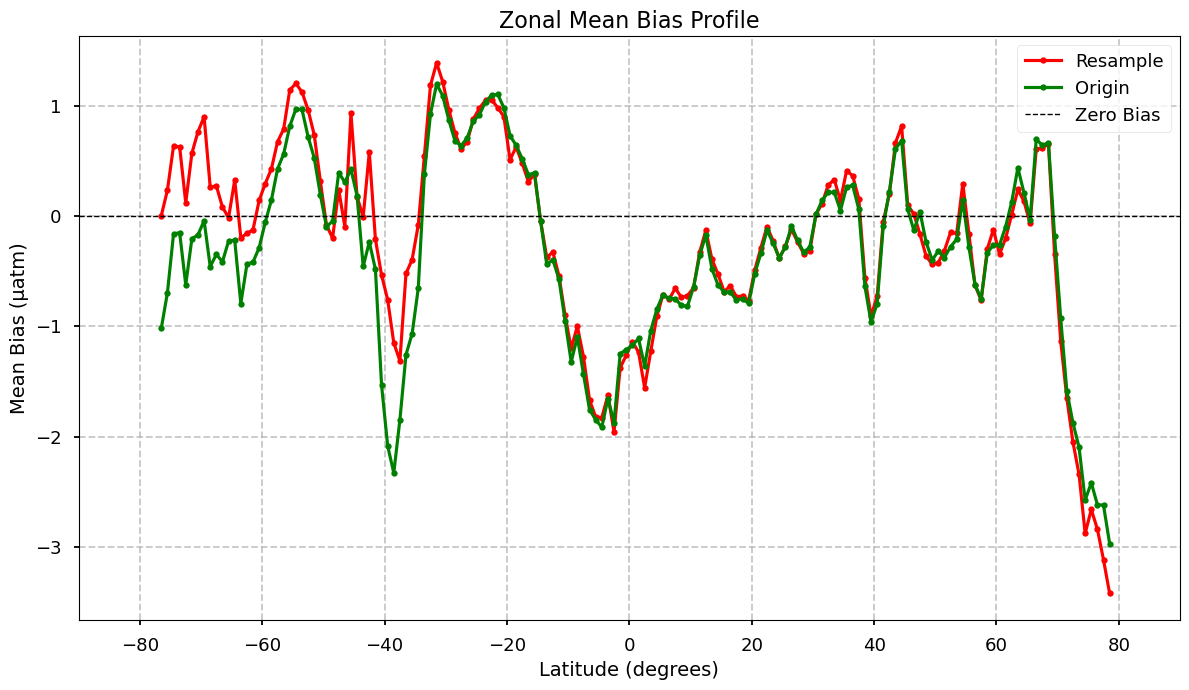

In [39]:
zonal_mean_bias1 = (ds_evalbias['bias'] * 1).mean('ens').mean('member').mean('time')
zonal_mean_bias1 = zonal_mean_bias1.mean(dim='xlon', skipna=True)

zonal_mean_bias2 = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
zonal_mean_bias2 = zonal_mean_bias2.mean(dim='xlon', skipna=True)

fig, ax = plt.subplots(figsize=(12, 7))

zonal_mean_bias1.plot.line(ax=ax, x='ylat', marker='.', linestyle='-', color='red', label='Resample')
zonal_mean_bias2.plot.line(ax=ax, x='ylat', marker='.', linestyle='-', color='green', label='Origin')

ax.set_xlabel("Latitude (degrees)", fontsize=14)
ax.set_ylabel("Mean Bias (µatm)", fontsize=14)
ax.set_title("Zonal Mean Bias Profile", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Bias')
ax.set_xlim(-90, 90)
ax.legend()

plt.tight_layout()
plt.show()

Fig 20: Zonal mean bias profile for the original model and bias-based resample model. Mean bias shifted from negative to positive for 60~80°S while significant bias reduction was observed for midlatitudes (~40°S).

**Conclusion**: In theory, it makes sense to focus new sampling in areas with the largest errors - this would be efficient. However, in practice, this research shows it's not always that straightforward.
This study investigated which specific ocean areas would provide the most valuable data when sampled, particularly for improving ocean model reconstruction. The findings suggest that sampling points between 35-50 degrees south latitude significantly help improve model accuracy. However, sampling points beyond 60 degrees south latitude didn't improve results as much as expected, likely due to the influence of Antarctica and the Antarctic continent.

# 4. Comparison between different masking methods

As the mean bias metric would average out positive and negative bias, here we used mean absolute error to compare the reconstruction performance of different sampling methods. Although there's no clear pattern regarding the amount of total samples with mean absolute bias, significant linearity was observed between total added sampling locations and the reduction in mean absolute bias. Although mirrorring contains more total samples, the argo method provides more non-repetitive sampling locations with more embedded unique information, and therefore is able to improve the reconstruction performance to a higher level with lower sampling efforts. Such results suggest that the design of sampling locations is more important to simply increasing sampling amounts, and it's crucial to optimize the sample distribution to make the most of limited sampling capacity. 

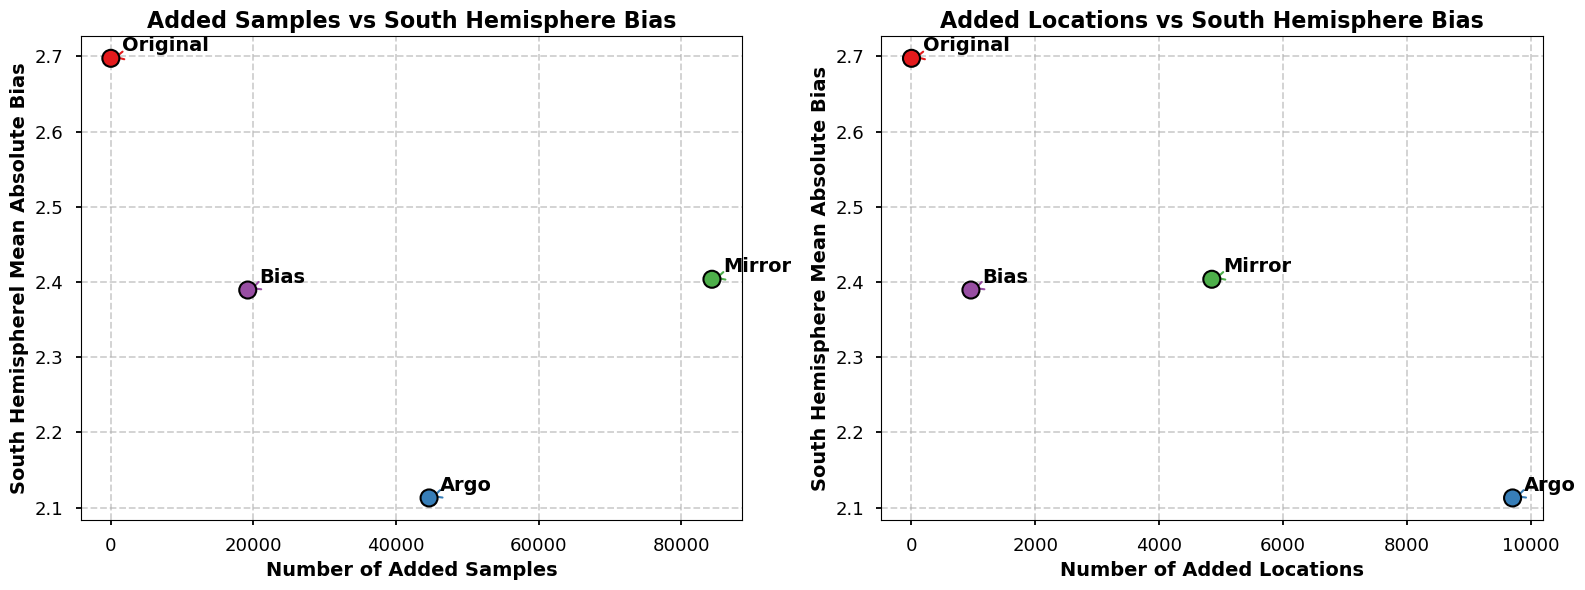

In [69]:
# Southern Hemisphere Bias
import seaborn as sns

methods = ['Original', 'Argo', 'Mirror', 'Bias']
added_points_samples = [0, total_added_points_argo, additional_points_added, 19200]  # additional samples
added_points_locations = [0, added_points_spatial_argo, n_new, 960]           # additional locations

south_bias_original = ds_eval_mean.sel(ylat=slice(-90, 0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_original = south_bias_original['bias'].abs().mean()
south_bias_argo = ds_eval_argo_mean.sel(ylat=slice(-90, 0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_argo = south_bias_argo['bias'].abs().mean()
south_bias_mirror = mir_ds_eval_mean.sel(ylat=slice(-90, 0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_mirror = south_bias_mirror['bias'].abs().mean()
south_bias_bias = ds_eval_meanbias.sel(ylat=slice(-90, 0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_bias = south_bias_bias['bias'].abs().mean()


mean_abs_bias = [mean_abs_bias_original, mean_abs_bias_argo, mean_abs_bias_mirror, mean_abs_bias_bias]

palette = sns.color_palette('Set1', len(methods))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ========== Added Samples vs Mean Absolute Bias ==========
axes[0].scatter(added_points_samples, mean_abs_bias, s=150, c=palette, edgecolors='black', linewidth=1.5, zorder=5)

for i, txt in enumerate(methods):
    axes[0].annotate(txt, (added_points_samples[i], mean_abs_bias[i]), textcoords="offset points", xytext=(8,5), ha='left', fontsize=14, fontweight='bold', 
        arrowprops=dict(arrowstyle="->", lw=1.5, color=palette[i]))

axes[0].set_xlabel('Number of Added Samples', fontsize=14, fontweight='bold')
axes[0].set_ylabel('South Hemispherel Mean Absolute Bias', fontsize=14, fontweight='bold')
axes[0].set_title('Added Samples vs South Hemisphere Bias', fontsize=16, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].spines['top'].set_visible(True)
axes[0].spines['right'].set_visible(True)

# ========== Added Locations vs Mean Absolute Bias ==========
axes[1].scatter(added_points_locations, mean_abs_bias, s=150, c=palette, edgecolors='black', linewidth=1.5, zorder=5)

for i, txt in enumerate(methods):
    axes[1].annotate(txt, (added_points_locations[i], mean_abs_bias[i]), textcoords="offset points", xytext=(8,5), ha='left', fontsize=14, fontweight='bold',
        arrowprops=dict(arrowstyle="->", lw=1.5, color=palette[i]))

axes[1].set_xlabel('Number of Added Locations', fontsize=14, fontweight='bold')
axes[1].set_ylabel('South Hemisphere Mean Absolute Bias', fontsize=14, fontweight='bold')
axes[1].set_title('Added Locations vs South Hemisphere Bias', fontsize=16, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].spines['top'].set_visible(True)
axes[1].spines['right'].set_visible(True)

plt.tight_layout()
plt.show()

Fig. 21: The comparison of mean absolute bias in the Southern ocean for different sampling methods with x-axis being (left) total added samples, and (right) total added locations.

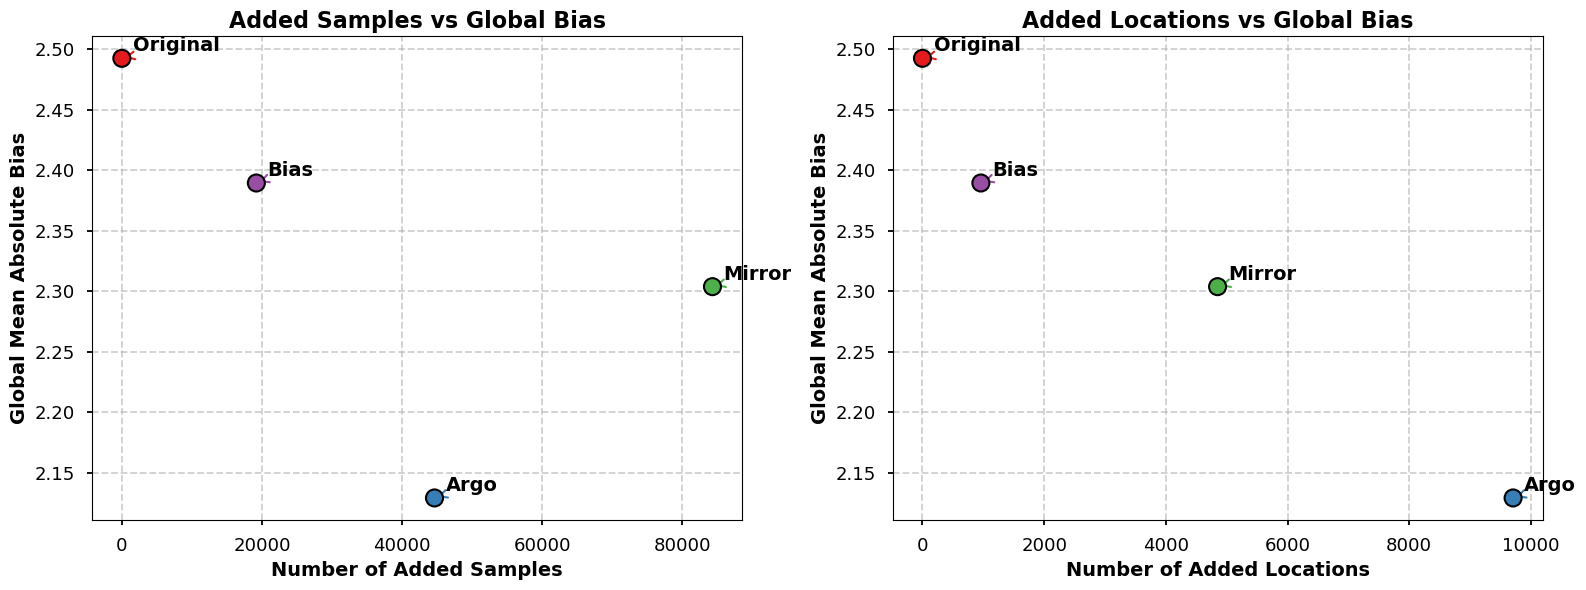

In [70]:
# Global Bias

global_bias_original = ds_eval_mean.sel(ylat=slice(-90, 90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_original = global_bias_original['bias'].abs().mean()
global_bias_argo = ds_eval_argo_mean.sel(ylat=slice(-90, 90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_argo = global_bias_argo['bias'].abs().mean()
global_bias_mirror = mir_ds_eval_mean.sel(ylat=slice(-90, 90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_mirror = global_bias_mirror['bias'].abs().mean()
south_bias_bias = ds_eval_meanbias.sel(ylat=slice(-90, 0)).stack(z=['ylat','xlon']).dropna('z').to_dataframe()
mean_abs_bias_bias = south_bias_bias['bias'].abs().mean()


mean_abs_bias = [mean_abs_bias_original, mean_abs_bias_argo, mean_abs_bias_mirror, mean_abs_bias_bias]

palette = sns.color_palette('Set1', len(methods))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ========== Added Samples vs Mean Absolute Bias ==========
axes[0].scatter(added_points_samples, mean_abs_bias, s=150, c=palette, edgecolors='black', linewidth=1.5, zorder=5)

for i, txt in enumerate(methods):
    axes[0].annotate(txt, (added_points_samples[i], mean_abs_bias[i]), textcoords="offset points", xytext=(8,5), ha='left', fontsize=14, fontweight='bold', 
        arrowprops=dict(arrowstyle="->", lw=1.5, color=palette[i]))

axes[0].set_xlabel('Number of Added Samples', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Global Mean Absolute Bias', fontsize=14, fontweight='bold')
axes[0].set_title('Added Samples vs Global Bias', fontsize=16, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].spines['top'].set_visible(True)
axes[0].spines['right'].set_visible(True)

# ========== Added Locations vs Mean Absolute Bias ==========
axes[1].scatter(added_points_locations, mean_abs_bias, s=150, c=palette, edgecolors='black', linewidth=1.5, zorder=5)

for i, txt in enumerate(methods):
    axes[1].annotate(txt, (added_points_locations[i], mean_abs_bias[i]), textcoords="offset points", xytext=(8,5), ha='left', fontsize=14, fontweight='bold',
        arrowprops=dict(arrowstyle="->", lw=1.5, color=palette[i]))

axes[1].set_xlabel('Number of Added Locations', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Global Mean Absolute Bias', fontsize=14, fontweight='bold')
axes[1].set_title('Added Locations vs Global Bias', fontsize=16, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].spines['top'].set_visible(True)
axes[1].spines['right'].set_visible(True)

plt.tight_layout()
plt.show()

Fig. 22: The comparison of mean absolute bias in all ocean areas for different sampling methods with x-axis being (left) total added samples, and (right) total added locations.

## Final Check for Redundant Files

In [65]:
if runthiscell == -1:   # Only reviewers should delete data under this path. Everyone should clear redundant data, but be cautious not to delete necessary files.
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    
    blobs = bucket.list_blobs(prefix=prefix)
    
    files_deleted = 0
    for blob in blobs:
        try:
            blob.delete()
            print(f"Deleted: {blob.name}")
            files_deleted += 1
        except Exception as e:
            print(f"Failed to delete: {blob.name}")
            print(e)
    
    if files_deleted > 0:
        print(f"Successfully deleted {files_deleted} files under {reviewing_owner}'s directory.")
    else:
        print(f"No files found for {reviewing_owner}. Nothing was deleted.")


# Summary:

This project aims to enhance both the precision and efficiency of reconstructing air–sea CO₂ fluxes, which is a critical component of understanding the global carbon cycle. Given the sparse and uneven coverage of oceanic pCO₂ measurements, especially in high-latitude and wintertime regions, machine learning techniques have become essential tools for estimating pCO₂. We leveraged the Large Ensemble Testbed (LET), which provides model-generated full-coverage pCO₂ fields that serve as ground truth for assessing ML reconstruction accuracy. Building on earlier work (Gloege et al. (2021) & Bennington et al. (2022)), the project implements the pCO₂-Residual method, which removes temperature-driven variability prior to applying ML (XGBoost), thereby improving the model’s sensitivity to non-temperature factors. However, evaluating the skill of these reconstructions is challenging due to the absence of full-coverage observational data.

To address this problem, our group implement Bio-Argo masking as well as SOCAT mirroring to improve the Large Ensemble Testbed (LET) modeling accuracy and reduce pCO₂ reconstructions costs. Bio-Argo floats collect biogeochemical parameters such as oxygen, pH, nitrate, and chlorophyll, which are essential for understanding oceanic carbon dynamics. By incorporating Bio-Argo data, we can significantly enhance the spatial and temporal resolution of surface ocean pCO₂ reconstructions. This is particularly valuable in remote and under-sampled regions like the Southern Ocean, where traditional ship-based observations are limited. In addition, applying a hemispheric mirroring technique can improve pCO₂ reconstructions as well. Reflecting values from the Northern Hemisphere to the Southern Hemisphere by inverting their latitudinal coordinates result in a more symmetrical and spatially complete dataset (and lss biased), which can be useful for training machine learning models and analyzing hemispheric patterns in ocean carbon dynamics. While this approach does not introduce new observations, it offers a creative way to explore potential pCO₂ distributions in data-limited regions and assess the robustness of reconstruction methods.

Our results show that Bio-Argo improved the pCO₂ reconstruction significantly, especially in the Southern Ocean with a mean bias of only -0.079. The 30% mirroring also improved the pCO₂ reconstruction, better than the original dataset but worse than Bio-Argo, with a mean bias of -0.14. Overall, these two approches proved to be more accurate and while being cost effective method for pCO₂ reconstructions.

## Contribution Statement:

Kechao found, uploaded, and cleaned the Bio-Argo data. Kechao also built the Bio-Argo masking for the pCO₂ reconstructions and created figures. Ahinoam started applying the hemispheric mirroring technique Ian built the SOCAT mirroring masking and running the ML reconstruction, plotted the figures and interprated them. Fangtong modeled and visualized resample in areas with the greatest bias to improve the ocean reconstruction results with fewer samples. Ahinoam wrote the introduction of the data story and the motivation behind the project. Ian, Kechao, Fangtong, and Ahinoam wrote the captions for the figures and the analyzed the results. All team members contributed to the GitHub repository and prepared the presentation. All team members approve our work presented in our GitHub repository including this contribution statement.

## References:
1. "Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability" , Gloege et al. (2021) https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020GB006788

2. "Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method" , Bennington et al. (2022) https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2021MS002960

3. Biogeochemical Argo (BGC-Argo) Dataset: https://biogeochemical-argo.org/key-areas-projects.php#filter=.pf-polar-areas

4. Nature’s "Ocean sensors can track progress on climate goals" (Russel, 2018) https://www.nature.com/articles/d41586-018-03068-w

5. Wikipedia "RV Investigator" https://en.wikipedia.org/wiki/RV_Investigator